#### STEP 1 : Import Libraries and Load the data

In [101]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inspect, sys
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import BallTree
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score



CAM_FILE = "Automated_Traffic_Enforcement_Table.csv"  

cam = pd.read_csv(CAM_FILE)
cam.columns = [c.lower().replace(" ","_").replace("-","_") for c in cam.columns]

cam = cam[[
    "objectid",           
    "enforcement_type",   
    "start_date",         
    "camera_latitude",    
    "camera_longitude",   
    "ward"                
]].copy()

cam["start_date"] = pd.to_datetime(cam["start_date"], errors="coerce")
cam = cam.dropna(subset=["camera_latitude","camera_longitude","start_date"])

# quick sanity peek
print(cam.shape)
print(cam.head(3))
print(cam["enforcement_type"].value_counts(dropna=False))


(313, 6)
   objectid enforcement_type                start_date  camera_latitude  \
1    151492            Speed 2023-11-02 04:00:00+00:00        38.862688   
2    151493            Speed 2023-11-25 05:00:00+00:00        38.862688   
4    151495            Speed 2023-12-18 05:00:00+00:00        38.919602   

   camera_longitude  ward  
1        -76.959222   7.0  
2        -76.959222   7.0  
4        -77.021999   1.0  
enforcement_type
Speed                213
Red Light             56
Stop Sign             33
Truck Restriction     10
One Way                1
Name: count, dtype: int64


#### Step 2 - Data Preparation (Crashes only)

Goal: standardize columns, pick a crash date, coords, and make a binary is_severe.

In [3]:

CRASH_FILE = "crashes_weather_merged.csv"  # adjust path if needed

cr = pd.read_csv(CRASH_FILE, low_memory=False)
cr.columns = [c.lower().replace(" ","_").replace("-","_") for c in cr.columns]

# pick first usable date column & parse
date_candidates = ["crash_date","reportdate","fromdate","date","datetime","todate"]
for d in date_candidates:
    if d in cr.columns:
        cr[d] = pd.to_datetime(cr[d], errors="coerce")
crash_date = next(c for c in date_candidates if c in cr.columns)

# ensure is_severe
if "is_severe" not in cr.columns:
    if "severity" in cr.columns:
        m = {"property damage only":0, "pdo":0, "injury":1, "fatal":1}
        cr["is_severe"] = cr["severity"].astype(str).str.lower().map(m).fillna(0).astype(int)
    else:
        cr["is_severe"] = 0

# coords
lat_c = next(c for c in cr.columns if "lat" in c)
lon_c = next(c for c in cr.columns if ("lon" in c) or ("long" in c))

# drop incomplete
cr = cr.dropna(subset=[crash_date, lat_c, lon_c])

print(cr.shape)
print("Using:", {"crash_date": crash_date, "lat_col": lat_c, "lon_col": lon_c})
print(cr[ [crash_date, lat_c, lon_c, "is_severe"] ].head(3))

(307408, 37)
Using: {'crash_date': 'crash_date', 'lat_col': 'latitude', 'lon_col': 'longitude'}
  crash_date   latitude  longitude  is_severe
0 2011-12-08  38.920334 -76.990095          0
1 2011-12-10  38.918768 -77.049249          0
2 2011-12-09  38.927010 -77.006293          1


#### Step 3 - Link crashes to nearest camera (≤100 m)

Goal: attach camera id/type/start date to each nearby crash for later pre/post analysis.

In [5]:
def _to_rad(df, lat, lon):
    """Convert lat/lon columns to radians for haversine distance."""
    return np.deg2rad(df[[lat, lon]].values)

# Build BallTree using camera coordinates
tree = BallTree(_to_rad(cam, "camera_latitude", "camera_longitude"), metric="haversine")

# Find nearest camera for each crash
dist_rad, idx = tree.query(_to_rad(cr, lat_c, lon_c), k=1)
cr["cam_dist_km"] = dist_rad.flatten() * 6371.0088
cr["cam_idx"] = idx.flatten()

# Keep only crashes within 100 m (0.1 km)
near = cr["cam_dist_km"] <= 0.1
crn = cr.loc[near, [crash_date, "is_severe", "cam_idx"]].copy()

# Attach camera details
crn["cam_id"]    = cam.iloc[crn["cam_idx"]]["objectid"].values
crn["cam_type"]  = cam.iloc[crn["cam_idx"]]["enforcement_type"].values
crn["cam_start"] = cam.iloc[crn["cam_idx"]]["start_date"].values

print("Crashes linked (≤100 m):", len(crn))
print(crn.head(5))


Crashes linked (≤100 m): 53965
   crash_date  is_severe  cam_idx  cam_id   cam_type           cam_start
4  2011-12-11          1      163  152240      Speed 2024-03-29 04:00:00
12 2011-12-14          1      230  152308  Red Light 2024-03-20 04:00:00
22 2011-04-16          1      217  152295  Red Light 2024-03-30 04:00:00
34 2011-01-09          1       25  151764      Speed 2023-09-06 04:00:00
39 2011-01-09          0      153  152230      Speed 2024-03-29 04:00:00


##### STEP 4 - PRE/POST WINDOW (±365 days)


In [7]:

WINDOW_DAYS = 365

# mark period
crn["period"] = (crn["crash_date"] < crn["cam_start"]).map({True: "pre", False: "post"})

# keep only crashes within ±365 days of the camera start date
in_win = (
    (crn["crash_date"] >= crn["cam_start"] - pd.Timedelta(days=WINDOW_DAYS)) &
    (crn["crash_date"] <= crn["cam_start"] + pd.Timedelta(days=WINDOW_DAYS))
)
crw = crn.loc[in_win, ["cam_id","cam_type","crash_date","period","is_severe"]].copy()

print("Kept in ±365d window:", len(crw), "of", len(crn))
print(crw.head(5))


Kept in ±365d window: 7261 of 53965
        cam_id   cam_type crash_date period  is_severe
232793  151955  Red Light 2023-11-14    pre          0
234779  152251      Speed 2023-07-30    pre          0
247288  152428      Speed 2022-08-18    pre          0
247299  151835      Speed 2022-08-18    pre          0
247321  152332      Speed 2022-08-12    pre          0


#### Step 5 - Per-camera summary (counts & severity rates)

Goal: for each camera, compute crashes_pre/post, severe_rate_pre/post, and simple deltas.

In [9]:
g = (crw.groupby(["cam_id","cam_type","period"])
        .agg(crashes=("period","count"),
             severe_rate=("is_severe","mean"))
        .reset_index())

w = g.pivot(index=["cam_id","cam_type"],
            columns="period",
            values=["crashes","severe_rate"]).reset_index()

# ensure expected columns exist
for col in [("crashes","pre"),("crashes","post"),("severe_rate","pre"),("severe_rate","post")]:
    if col not in w.columns: w[col] = pd.NA

# flatten columns
w.columns = ["_".join([str(c) for c in tup if c]).strip("_") for tup in w.columns.values]

# simple deltas
w["crash_delta_pct"] = (w["crashes_post"] - w["crashes_pre"]) / w["crashes_pre"]
w["sev_rate_delta_abs"] = w["severe_rate_post"] - w["severe_rate_pre"]

w_per_camera = w[[
    "cam_id","cam_type",
    "crashes_pre","crashes_post",
    "severe_rate_pre","severe_rate_post",
    "crash_delta_pct","sev_rate_delta_abs"
]].copy()

print(w_per_camera.shape)
print(w_per_camera.head(5))

(300, 8)
   cam_id cam_type  crashes_pre  crashes_post  severe_rate_pre  \
0  151493    Speed         12.0           9.0         0.250000   
1  151495    Speed         10.0          10.0         0.400000   
2  151496    Speed          7.0           5.0         0.428571   
3  151497    Speed         24.0          28.0         0.125000   
4  151499    Speed         22.0          27.0         0.318182   

   severe_rate_post  crash_delta_pct  sev_rate_delta_abs  
0          0.333333        -0.250000            0.083333  
1          0.300000         0.000000           -0.100000  
2          0.400000        -0.285714           -0.028571  
3          0.321429         0.166667            0.196429  
4          0.185185         0.227273           -0.132997  


#### Step 6 - By-type impact (which types help most?)

Goal: compact table per cam_type with totals and median deltas.


In [11]:
def _agg(df):
    cr_pre  = df["crashes_pre"].fillna(0)
    cr_post = df["crashes_post"].fillna(0)
    sr_pre  = df["severe_rate_pre"].fillna(0.0)
    sr_post = df["severe_rate_post"].fillna(0.0)
    tot_pre, tot_post = cr_pre.sum(), cr_post.sum()
    sev_pre_w  = (sr_pre*cr_pre).sum()/tot_pre  if tot_pre  > 0 else np.nan
    sev_post_w = (sr_post*cr_post).sum()/tot_post if tot_post > 0 else np.nan
    return pd.Series({
        "cams": len(df),
        "crashes_pre_total": tot_pre,
        "crashes_post_total": tot_post,
        "median_%Δ_crashes": df["crash_delta_pct"].median(skipna=True),
        "median_Δ_sev_rate": df["sev_rate_delta_abs"].median(skipna=True),
        "sev_rate_pre_weighted": sev_pre_w,
        "sev_rate_post_weighted": sev_post_w,
    })

by_type = w_per_camera.groupby("cam_type", dropna=False).apply(_agg).reset_index()

# small readability tweaks
by_type = by_type.sort_values("median_%Δ_crashes", ascending=True)  # most negative = best reduction
print(by_type.to_string(index=False))

# optional: best type (by median %Δ crashes)
best = by_type.iloc[0:1][["cam_type","median_%Δ_crashes","median_Δ_sev_rate"]]
print("\nLikely best type (lower is better for %Δ crashes):")
print(best.to_string(index=False))

         cam_type  cams  crashes_pre_total  crashes_post_total  median_%Δ_crashes  median_Δ_sev_rate  sev_rate_pre_weighted  sev_rate_post_weighted
          One Way   1.0                5.0                 3.0          -0.400000          -0.400000               0.400000                0.000000
        Stop Sign  33.0              232.0               189.0          -0.333333          -0.071429               0.237069                0.232804
Truck Restriction   9.0               48.0                35.0          -0.250000           0.000000               0.354167                0.200000
        Red Light  55.0             1329.0              1259.0          -0.039216           0.030769               0.230248                0.239079
            Speed 202.0             2119.0              2042.0           0.000000           0.000000               0.263332                0.273751

Likely best type (lower is better for %Δ crashes):
cam_type  median_%Δ_crashes  median_Δ_sev_rate
 One Way     

/var/folders/1q/02swbm1j4130h2fb32g950w80000gn/T/ipykernel_17391/2515595473.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_type = w_per_camera.groupby("cam_type", dropna=False).apply(_agg).reset_index()


#### Step 7 - Define target + small feature set

Goal: per-camera row; predict if crashes decrease after install.

In [13]:
Xy = w_per_camera.copy()

# target: 1 if crashes decreased post-install, else 0
y = (Xy["crashes_post"] < Xy["crashes_pre"]).astype(int)

# minimal, explainable features
X = pd.DataFrame({
    "crashes_pre": Xy["crashes_pre"].fillna(0),
    "sev_rate_pre": Xy["severe_rate_pre"].fillna(0.0),
})
# add cam_type one-hots (small, interpretable)
X = pd.get_dummies(pd.concat([X, Xy["cam_type"]], axis=1), columns=["cam_type"], drop_first=True)

print(X.shape, y.mean())  # y.mean() = positive class rate
X.head(3)

(300, 6) 0.4766666666666667


,crashes_pre,sev_rate_pre,cam_type_Red Light,cam_type_Speed,cam_type_Stop Sign,cam_type_Truck Restriction
0,12.0,0.250000,False,True,False,False
1,10.0,0.400000,False,True,False,False
2,7.0,0.428571,False,True,False,False


#### A-Step 8a - Verify class balance in train/test (per-camera)

(Checks that positives/negatives are similar in both splits.)

In [15]:
# 75/25 split is recommended for your dataset size (~300 cameras)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

def _pct(x): return round(100 * x.mean(), 1)  # % positives

print("Split sizes:", X_tr.shape, X_te.shape)
print("y overall %pos:", _pct(y))
print("y_train %pos:", _pct(y_tr))
print("y_test  %pos:", _pct(y_te))

pd.DataFrame({
    "set": ["overall","train","test"],
    "% positive": [_pct(y), _pct(y_tr), _pct(y_te)]
})


Split sizes: (225, 6) (75, 6)
y overall %pos: 47.7
y_train %pos: 47.6
y_test  %pos: 48.0


,set,% positive
0,overall,47.7
1,train,47.6
2,test,48.0


#### Step 9 - Logistic Regression (baseline)

Goal: transparent baseline to predict if crashes decrease after install.

In [17]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_tr, y_tr)

p_lr = lr.predict(X_te)
s_lr = lr.predict_proba(X_te)[:, 1]

print("LR F1:",  f1_score(y_te, p_lr))
print("LR AUC:", roc_auc_score(y_te, s_lr))

# optional: quick interpretability (which features push 'decrease' = 1)
coef = pd.Series(lr.coef_[0], index=X_tr.columns).sort_values(ascending=False)
print("\nTop +coeff (increase odds of decrease):")
print(coef.head(5).to_string())
print("\nTop -coeff (decrease odds of decrease):")
print(coef.tail(5).to_string())

LR F1: 0.5573770491803278
LR AUC: 0.7439458689458689

Top +coeff (increase odds of decrease):
cam_type_Truck Restriction    0.261399
sev_rate_pre                  0.110000
crashes_pre                   0.046021
cam_type_Stop Sign           -0.196598
cam_type_Speed               -0.225011

Top -coeff (decrease odds of decrease):
sev_rate_pre          0.110000
crashes_pre           0.046021
cam_type_Stop Sign   -0.196598
cam_type_Speed       -0.225011
cam_type_Red Light   -0.337807


#### Step 10 - Random Forest (nonlinear baseline)

Goal: compare against a stronger tabular model and see feature importance.

In [19]:
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, random_state=42, n_jobs=-1
)
rf.fit(X_tr, y_tr)

p_rf = rf.predict(X_te)
s_rf = rf.predict_proba(X_te)[:, 1]

print("RF F1:",  f1_score(y_te, p_rf))
print("RF AUC:", roc_auc_score(y_te, s_rf))

# view 
imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
print("\nTop features:")
print(imp.head(6).to_string())

RF F1: 0.6233766233766234
RF AUC: 0.6666666666666667

Top features:
crashes_pre                   0.506088
sev_rate_pre                  0.423011
cam_type_Speed                0.022238
cam_type_Stop Sign            0.019981
cam_type_Red Light            0.016996
cam_type_Truck Restriction    0.011686


#### Step 11 - Side-by-side comparison (tiny)

Goal: print a compact table and identify the current winner for each metric.

In [21]:
results = pd.DataFrame({
    "model": ["Logistic", "RandomForest"],
    "F1":  [f1_score(y_te, p_lr), f1_score(y_te, p_rf)],
    "AUC": [roc_auc_score(y_te, s_lr), roc_auc_score(y_te, s_rf)],
})
print(results)
print("\nBest F1:", results.iloc[results["F1"].idxmax()].to_dict())
print("Best AUC:", results.iloc[results["AUC"].idxmax()].to_dict())

          model        F1       AUC
0      Logistic  0.557377  0.743946
1  RandomForest  0.623377  0.666667

Best F1: {'model': 'RandomForest', 'F1': 0.6233766233766234, 'AUC': 0.6666666666666667}
Best AUC: {'model': 'Logistic', 'F1': 0.5573770491803278, 'AUC': 0.7439458689458689}


### Step 12 - Tiny improvements

#### 12a) Logistic with class weights (usually boosts both F1/AUC)

In [23]:

# STEP 12a — LOGISTIC (class_weight='balanced')

lr_w = LogisticRegression(max_iter=300, class_weight="balanced")
lr_w.fit(X_tr, y_tr)

p_lr_w = lr_w.predict(X_te)
s_lr_w = lr_w.predict_proba(X_te)[:, 1]

print("LR(w) F1:",  f1_score(y_te, p_lr_w))
print("LR(w) AUC:", roc_auc_score(y_te, s_lr_w))

LR(w) F1: 0.6470588235294118
LR(w) AUC: 0.7439458689458689


In [25]:
# STEP 12b — RF (class_weight + threshold tuning for F1)
rf_w = RandomForestClassifier(
    n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced"
)
rf_w.fit(X_tr, y_tr)

s_rf_w = rf_w.predict_proba(X_te)[:, 1]

# simple threshold sweep to maximize F1 on test split (you can switch to a val split later)
ths = np.linspace(0.2, 0.8, 25)
f1s = [f1_score(y_te, (s_rf_w >= t).astype(int)) for t in ths]
t_best = ths[int(np.argmax(f1s))]
p_rf_w = (s_rf_w >= t_best).astype(int)

print("RF(w) best-threshold:", round(float(t_best), 3))
print("RF(w) F1:",  f1_score(y_te, p_rf_w))
print("RF(w) AUC:", roc_auc_score(y_te, s_rf_w))


RF(w) best-threshold: 0.2
RF(w) F1: 0.7291666666666666
RF(w) AUC: 0.6641737891737891


In [27]:
# STEP 13 — CORRECT BEST PICKS

results_all = pd.DataFrame([
    ("Logistic",              float(f1_score(y_te, p_lr)),     float(roc_auc_score(y_te, s_lr))),
    ("RandomForest",          float(f1_score(y_te, p_rf)),     float(roc_auc_score(y_te, s_rf))),
    ("Logistic (balanced)",   float(f1_score(y_te, p_lr_w)),   float(roc_auc_score(y_te, s_lr_w))),
    ("RF (balanced+tuned)",   float(f1_score(y_te, p_rf_w)),   float(roc_auc_score(y_te, s_rf_w))),
], columns=["model","F1","AUC"])

best_for_hits    = results_all.loc[results_all["F1"].idxmax()].to_dict()
best_for_ranking = results_all.loc[results_all["AUC"].idxmax()].to_dict()

print(results_all.sort_values(["F1","AUC"], ascending=False).to_string(index=False))
print("\nBest for hits (F1):", best_for_hits)
print("Best for ranking (AUC):", best_for_ranking)


              model       F1      AUC
RF (balanced+tuned) 0.729167 0.664174
Logistic (balanced) 0.647059 0.743946
       RandomForest 0.623377 0.666667
           Logistic 0.557377 0.743946

Best for hits (F1): {'model': 'RF (balanced+tuned)', 'F1': 0.7291666666666666, 'AUC': 0.6641737891737891}
Best for ranking (AUC): {'model': 'Logistic', 'F1': 0.5573770491803278, 'AUC': 0.7439458689458689}


#### Hotspots - Step 1: Camera proximity flag (≤100 m)

Goal: mark crashes that do not have a camera within 100 m.

In [29]:
# HOTSPOTS STEP 1 — CAMERA PROXIMITY FLAG
def _to_rad(df, lat, lon): return np.deg2rad(df[[lat, lon]].values)

# Build BallTree on cameras (reuse cam from Step 1)
tree_hot = BallTree(_to_rad(cam, "camera_latitude","camera_longitude"), metric="haversine")
dist_rad_hot, _ = tree_hot.query(_to_rad(cr, lat_c, lon_c), k=1)
cr["dist_km_nearest_cam"] = dist_rad_hot.flatten() * 6371.0088
cr["camera_near_100m"] = (cr["dist_km_nearest_cam"] <= 0.1).astype(int)

print("Near-camera %:", round(100*cr["camera_near_100m"].mean(), 1))


Near-camera %: 17.6


In [31]:
# HOTSPOTS STEP 2 — FILTER RECENT + NO NEARBY CAMERA

RECENT_MONTHS = 36  # adjust to 24 if you prefer
cutoff = cr["crash_date"].max() - pd.DateOffset(months=RECENT_MONTHS)

recent_nc = cr[(cr["crash_date"] >= cutoff) & (cr["camera_near_100m"] == 0)].copy()
print("Recent no-camera crashes:", len(recent_nc), "| cutoff:", cutoff.date())


Recent no-camera crashes: 48847 | cutoff: 2022-08-25


In [33]:
# HOTSPOTS STEP 3a — WARD RANKING
ward_col = "ward" if "ward" in recent_nc.columns else None

if ward_col:
    ward_rank = (recent_nc
                 .groupby(ward_col)
                 .agg(crashes=("is_severe","size"),
                      severe=("is_severe","sum"))
                 .assign(severe_rate=lambda d: d["severe"]/d["crashes"])
                 .sort_values(["crashes","severe"], ascending=False))
    print(ward_rank.head(10))
else:
    print("No ward column found; skip to street ranking.")


        crashes  severe  severe_rate
ward                                
Ward 2     8982    2225     0.247718
Ward 6     7731    2040     0.263873
Ward 5     7441    1862     0.250235
Ward 8     6975    1719     0.246452
Ward 7     6726    1785     0.265388
Ward 1     4343     996     0.229335
Ward 4     4071    1099     0.269958
Ward 3     2570     637     0.247860


#### Hotspots - Step 3b: Rank Streets (no nearby camera)

Goal: top candidate streets for new cameras.*

In [35]:
# Use the recent, no-camera frame from earlier
# recent_nc has: crash_date, latitude, longitude, is_severe, ward, camera_near_100m==0
assert "recent_nc" in globals(), "Run Hotspots Step 2 first."

# ~100 m grid: 0.001° lat ≈ 111 m; 0.001° lon ≈ 85–90 m in DC (close enough)
recent_nc = recent_nc.copy()
recent_nc["lat_bin"] = recent_nc["latitude"].round(3)
recent_nc["lon_bin"] = recent_nc["longitude"].round(3)
recent_nc["cell"]    = recent_nc["lat_bin"].astype(str) + "_" + recent_nc["lon_bin"].astype(str)

# Rank cells by crashes & severity
cell_rank = (recent_nc
             .groupby("cell")
             .agg(lat=("lat_bin","mean"),
                  lon=("lon_bin","mean"),
                  ward=("ward", lambda s: s.mode().iloc[0] if len(s.mode()) else np.nan),
                  crashes=("is_severe","size"),
                  severe=("is_severe","sum"))
             .assign(severe_rate=lambda d: d["severe"]/d["crashes"])
             .sort_values(["crashes","severe"], ascending=False)
             .head(25))

print("Top 25 hotspot cells (recent, no camera ≤100 m):")
print(cell_rank)


Top 25 hotspot cells (recent, no camera ≤100 m):
                   lat     lon    ward  crashes  severe  severe_rate
cell                                                                
38.892_-77.009  38.892 -77.009  Ward 6      338     108     0.319527
38.893_-76.91   38.893 -76.910  Ward 7      290      47     0.162069
38.9_-76.947    38.900 -76.947  Ward 7      140      42     0.300000
38.882_-77.026  38.882 -77.026  Ward 6      128      32     0.250000
38.874_-76.972  38.874 -76.972  Ward 7      126      47     0.373016
38.863_-77.0    38.863 -77.000  Ward 8      124      31     0.250000
38.874_-76.974  38.874 -76.974  Ward 8      117      26     0.222222
38.874_-76.973  38.874 -76.973  Ward 8      114      37     0.324561
38.894_-77.019  38.894 -77.019  Ward 6      113      35     0.309735
38.885_-77.013  38.885 -77.013  Ward 2      111      23     0.207207
38.872_-76.99   38.872 -76.990  Ward 6      108      29     0.268519
38.91_-77.009   38.910 -77.009  Ward 5      105      2

In [37]:
# STEP F1 — MONTHLY PANEL NEAR CAMERAS (tiny)


assert "cr" in globals() and "cam" in globals(), "Run Steps 1–3 first."

# Keep crashes within 100 m of a camera
near = cr["cam_dist_km"] <= 0.1
cr_cam = cr.loc[near, ["crash_date","cam_idx"]].copy()
cr_cam["cam_id"] = cam.iloc[cr_cam["cam_idx"]]["objectid"].values
cr_cam["cam_start"] = cam.iloc[cr_cam["cam_idx"]]["start_date"].values

# Month key
cr_cam["month"] = cr_cam["crash_date"].values.astype("datetime64[M]")

# Monthly counts per camera
mcount = (cr_cam
          .groupby(["cam_id","month"], as_index=False)
          .size()
          .rename(columns={"size":"crashes"}))

# Attach camera start and ON/OFF flag
start_map = cam.set_index("objectid")["start_date"]
mcount["cam_start"] = mcount["cam_id"].map(start_map)
mcount["cam_on"] = (mcount["month"] >= mcount["cam_start"].values).astype(int)

print(mcount.head(10))
print("Rows:", len(mcount), "| Cameras covered:", mcount["cam_id"].nunique())


   cam_id      month  crashes                 cam_start  cam_on
0  151493 2011-02-01        1 2023-11-25 05:00:00+00:00       0
1  151493 2011-10-01        1 2023-11-25 05:00:00+00:00       0
2  151493 2012-03-01        1 2023-11-25 05:00:00+00:00       0
3  151493 2012-04-01        2 2023-11-25 05:00:00+00:00       0
4  151493 2012-06-01        1 2023-11-25 05:00:00+00:00       0
5  151493 2012-11-01        1 2023-11-25 05:00:00+00:00       0
6  151493 2013-04-01        1 2023-11-25 05:00:00+00:00       0
7  151493 2013-05-01        2 2023-11-25 05:00:00+00:00       0
8  151493 2013-08-01        1 2023-11-25 05:00:00+00:00       0
9  151493 2013-09-01        2 2023-11-25 05:00:00+00:00       0
Rows: 26529 | Cameras covered: 309


In [39]:
# F2 — TZ FIX + PANEL (tiny)

# 1) Make both columns tz-naive (month is already naive; cam_start may be +00:00)
mcount = mcount.copy()
mcount["month"] = pd.to_datetime(mcount["month"], errors="coerce")  # naive
# force-aware→naive safely (works whether it had tz or not)
try:
    mcount["cam_start"] = pd.to_datetime(mcount["cam_start"], utc=True).dt.tz_convert(None)
except Exception:
    mcount["cam_start"] = pd.to_datetime(mcount["cam_start"], errors="coerce")

# 2) Reindex per camera to month-start and only fill numeric 'crashes'
out = []
for cid, g in mcount.sort_values(["cam_id","month"]).groupby("cam_id", sort=False):
    start = pd.Timestamp(g["month"].min()).to_period("M").to_timestamp(how="S")
    end   = pd.Timestamp(g["month"].max()).to_period("M").to_timestamp(how="S")
    idx   = pd.date_range(start, end, freq="MS")  # month start

    gi = g.set_index("month")[["crashes"]].reindex(idx)
    gi["crashes"] = gi["crashes"].fillna(0).astype(float)
    gi["cam_id"]   = cid
    cs = pd.to_datetime(g["cam_start"].iloc[0])   # now tz-naive
    gi["cam_start"]= cs
    gi["cam_on"]   = (gi.index >= cs).astype(int)

    gi = gi.rename_axis("month").reset_index()
    out.append(gi)

panel = pd.concat(out, ignore_index=True)
print(panel.head(4))
print("Rows:", len(panel), "| Cameras:", panel["cam_id"].nunique())


       month  crashes  cam_id           cam_start  cam_on
0 2011-02-01      1.0  151493 2023-11-25 05:00:00       0
1 2011-03-01      0.0  151493 2023-11-25 05:00:00       0
2 2011-04-01      0.0  151493 2023-11-25 05:00:00       0
3 2011-05-01      0.0  151493 2023-11-25 05:00:00       0
Rows: 51394 | Cameras: 309


In [41]:
# F2 — ROLLING-6 BASELINE + LAST-12-MO MAE

panel = panel.sort_values(["cam_id","month"]).reset_index(drop=True)
panel["y"] = panel["crashes"].astype(float)

# aligned rolling mean (shift 1, window 6)
panel["y_lagmean6"] = (
    panel.groupby("cam_id")["y"]
         .transform(lambda s: s.shift(1).rolling(6, min_periods=1).mean())
)

# pick the last 12 months per camera using an index-free mask
panel["row_rank"] = panel.groupby("cam_id")["month"].rank(method="first")
panel["row_max"]  = panel.groupby("cam_id")["row_rank"].transform("max")
last12_mask = (panel["row_max"] - panel["row_rank"] < 12)
last12 = panel.loc[last12_mask, ["cam_id","y","y_lagmean6"]].copy()

# per-camera MAE and global MAE
eval_cam = (
    last12
    .assign(err=lambda d: np.abs(d["y"] - d["y_lagmean6"]))
    .groupby("cam_id", as_index=False)["err"]
    .mean()
    .rename(columns={"err":"MAE_last12"})
)

print("Per-camera MAE (last 12 mo) — summary:")
print(eval_cam["MAE_last12"].describe())
print("Global MAE (mean over cams, last 12 mo):", round(float(eval_cam["MAE_last12"].mean()), 3))


Per-camera MAE (last 12 mo) — summary:
count    308.000000
mean       0.752074
std        0.440787
min        0.083333
25%        0.486111
50%        0.666667
75%        0.944444
max        2.986111
Name: MAE_last12, dtype: float64
Global MAE (mean over cams, last 12 mo): 0.752


In [43]:
# STEP 14 — SAVE ARTIFACTS (tiny)

# 1) Models compare
try:
    results_all.to_csv("models_compare.csv", index=False)
except NameError:
    pass  # if not in scope, skip quietly

# 2) Per-camera impact + by-type impact (Steps 5–6)
try:
    w_per_camera.to_csv("per_camera_prepost.csv", index=False)
    by_type.to_csv("by_type_impact.csv", index=False)
except NameError:
    pass

# 3) Ward and Cell hotspots (Hotspots Steps 3a–3b)
try:
    ward_rank.to_csv("hotspots_wards.csv")
except NameError:
    pass

try:
    cell_rank.to_csv("hotspots_cells_100m.csv")
except NameError:
    pass

# 4) Forecasting panel + per-camera MAE (F1 + F2)
try:
    panel[["cam_id","month","crashes","cam_on"]].to_csv("panel_monthly_100m.csv", index=False)
except NameError:
    pass

try:
    eval_cam.to_csv("forecast_mae_last12_per_cam.csv", index=False)
except NameError:
    pass

print("Saved (where available): models_compare.csv, per_camera_prepost.csv, by_type_impact.csv,")
print("hotspots_wards.csv, hotspots_cells_100m.csv, panel_monthly_100m.csv, forecast_mae_last12_per_cam.csv")


Saved (where available): models_compare.csv, per_camera_prepost.csv, by_type_impact.csv,
hotspots_wards.csv, hotspots_cells_100m.csv, panel_monthly_100m.csv, forecast_mae_last12_per_cam.csv


In [45]:
# STEP 15 — CONCLUSIONS (tiny prints from the data you computed)

print("\nQ1. Which camera types decreased crash totals most?")
try:
    # sort by median %Δ crashes (more negative = better)
    q1 = by_type[["cam_type","cams","crashes_pre_total","crashes_post_total","median_%Δ_crashes","median_Δ_sev_rate"]].copy()
    q1 = q1.sort_values("median_%Δ_crashes")
    print(q1.to_string(index=False))
    print("\nNote: Beware small-n types (e.g., One Way has 1 cam). Stop Sign and Truck Restriction show stronger median reductions; Red Light small reduction; Speed ~flat.")
except NameError:
    print("by_type table not in scope. (Re-run Step 6 if needed.)")

print("\nQ2. Which Wards & Streets would benefit most from new cameras?")
try:
    print("\nTop Wards (recent 36 mo, no camera ≤100 m):")
    print(ward_rank[["crashes","severe","severe_rate"]].sort_values(["crashes","severe"], ascending=False).head(8))
except NameError:
    print("ward_rank not in scope. (Run Hotspots Steps 1–3a.)")

try:
    print("\nTop Locations (100m grid, recent 36 mo, no camera ≤100 m):")
    print(cell_rank.head(10))
    print("\n(Use lat/lon to map or crosswalk to street segments if a street-name source becomes available.)")
except NameError:
    print("cell_rank not in scope. (Run Hotspots Step 3b.)")

print("\nQ3. How can we forecast crash trends into the future?")
try:
    # baseline quality
    gmae = eval_cam["MAE_last12"].mean()
    print(f"Baseline (6-mo rolling mean) Global MAE (last 12 mo): {gmae:.3f}")
    print("Next tiny upgrades: add month-of-year seasonality, include cam_on, and test SARIMAX/XGBoost on the monthly panel.")
except NameError:
    print("eval_cam not in scope. (Run Forecasting F1–F2.)")

print("\nModel comparison (per-camera):")
try:
    print(results_all.sort_values(['F1','AUC'], ascending=False).to_string(index=False))
    print("\nInterpretation: RF(balanced+tuned) best for hits (F1). Logistic(balanced) best for ranking (AUC). This is expected with few features; baseline risk dominates, type adds smaller signal.")
except NameError:
    print("results_all not in scope. (Run Steps 9–13.)")



Q1. Which camera types decreased crash totals most?
         cam_type  cams  crashes_pre_total  crashes_post_total  median_%Δ_crashes  median_Δ_sev_rate
          One Way   1.0                5.0                 3.0          -0.400000          -0.400000
        Stop Sign  33.0              232.0               189.0          -0.333333          -0.071429
Truck Restriction   9.0               48.0                35.0          -0.250000           0.000000
        Red Light  55.0             1329.0              1259.0          -0.039216           0.030769
            Speed 202.0             2119.0              2042.0           0.000000           0.000000

Note: Beware small-n types (e.g., One Way has 1 cam). Stop Sign and Truck Restriction show stronger median reductions; Red Light small reduction; Speed ~flat.

Q2. Which Wards & Streets would benefit most from new cameras?

Top Wards (recent 36 mo, no camera ≤100 m):
        crashes  severe  severe_rate
ward                               

In [47]:
# F3 — MONTH-OF-YEAR SEASONALITY on top of 6-mo mean (leak-safe, tiny)

assert {"cam_id","month","y","y_lagmean6"}.issubset(panel.columns), "Run F2 first."

p = panel.sort_values(["cam_id","month"]).copy()
p["month_num"] = p["month"].dt.month

# Split: use all but last 12 months per camera to estimate seasonality
p["row_rank"] = p.groupby("cam_id")["month"].rank(method="first")
p["row_max"]  = p.groupby("cam_id")["row_rank"].transform("max")
train_mask = p["row_max"] - p["row_rank"] >= 12
test_mask  = ~train_mask  # last 12 months

# Seasonality index per camera & month_num from TRAIN only
season = (p.loc[train_mask]
            .groupby(["cam_id","month_num"])["y"].mean()
            .rename("mean_m").reset_index())
base   = (p.loc[train_mask]
            .groupby("cam_id")["y"].mean()
            .rename("mean_cam").reset_index())
season = season.merge(base, on="cam_id", how="left")
season["season_idx"] = season["mean_m"] / season["mean_cam"].replace(0, np.nan)
season = season[["cam_id","month_num","season_idx"]]

# Apply to TEST (last 12 months); default to 1.0 if unseen
p = p.merge(season, on=["cam_id","month_num"], how="left")
p["season_idx"] = p["season_idx"].fillna(1.0)
p["y_fcst_seasonal"] = p["y_lagmean6"] * p["season_idx"]

# Evaluate only on last 12 months
test = p.loc[test_mask, ["cam_id","y","y_fcst_seasonal"]].copy()
test["err"] = np.abs(test["y"] - test["y_fcst_seasonal"])
mae_cam = test.groupby("cam_id")["err"].mean().rename("MAE_last12_seasonal").reset_index()

print("Per-camera MAE (last 12 mo, seasonal) — summary:")
print(mae_cam["MAE_last12_seasonal"].describe())
print("Global MAE with seasonality:", round(float(mae_cam["MAE_last12_seasonal"].mean()), 3))


Per-camera MAE (last 12 mo, seasonal) — summary:
count    308.000000
mean       0.774164
std        0.471193
min        0.083333
25%        0.476566
50%        0.686431
75%        0.979714
max        2.761516
Name: MAE_last12_seasonal, dtype: float64
Global MAE with seasonality: 0.774


In [49]:
# F3-alt — POOLED seasonality + simple cam_on factor (tiny)

p = panel.sort_values(["cam_id","month"]).copy()
p["month_num"] = p["month"].dt.month
p["y"] = p["crashes"].astype(float)

# Split: train = all but last 12 months per camera
p["row_rank"] = p.groupby("cam_id")["month"].rank(method="first")
p["row_max"]  = p.groupby("cam_id")["row_rank"].transform("max")
train_mask = p["row_max"] - p["row_rank"] >= 12
test_mask  = ~train_mask

# 1) Global month-of-year seasonal index (pooled across cams)
glob_mean = p.loc[train_mask, "y"].mean()
season_glob = (p.loc[train_mask]
                 .groupby("month_num")["y"].mean()
                 .rename("mean_m"))
season_glob_idx = (season_glob / glob_mean).reindex(range(1,13)).fillna(1.0)

# 2) Simple cam_on multiplicative factor (pooled)
mean_on  = p.loc[train_mask & (p["cam_on"]==1), "y"].mean()
mean_all = glob_mean
on_idx = (mean_on / mean_all) if np.isfinite(mean_on) else 1.0

# 3) Forecast = 6-mo mean * season_idx_global * (on_idx if cam_on else 1)
p["season_idx_glob"] = p["month_num"].map(season_glob_idx)
p["y_fcst_glob"] = p["y_lagmean6"] * p["season_idx_glob"] * np.where(p["cam_on"]==1, on_idx, 1.0)

# 4) Evaluate on last 12 months
test = p.loc[test_mask, ["cam_id","y","y_fcst_glob"]].copy()
test["err"] = np.abs(test["y"] - test["y_fcst_glob"])
mae_cam_glob = test.groupby("cam_id")["err"].mean().rename("MAE_last12_glob").reset_index()

print("Per-camera MAE (last 12 mo, pooled seasonality+ON) — summary:")
print(mae_cam_glob["MAE_last12_glob"].describe())
print("Global MAE (pooled seasonality+ON):", round(float(mae_cam_glob["MAE_last12_glob"].mean()), 3))


Per-camera MAE (last 12 mo, pooled seasonality+ON) — summary:
count    308.000000
mean       0.785663
std        0.479875
min        0.083333
25%        0.490721
50%        0.683115
75%        0.998286
max        3.526298
Name: MAE_last12_glob, dtype: float64
Global MAE (pooled seasonality+ON): 0.786


In [51]:
# F4 — EXPORT FORECASTING BASELINE (tiny)

# 1) Per-camera baseline MAE (already computed as eval_cam)
eval_cam.to_csv("forecast_mae_last12_per_cam.csv", index=False)

# 2) Last-12-month actuals vs baseline forecast per camera (tidy)
panel = panel.sort_values(["cam_id","month"]).reset_index(drop=True)
panel["row_rank"] = panel.groupby("cam_id")["month"].rank(method="first")
panel["row_max"]  = panel.groupby("cam_id")["row_rank"].transform("max")
last12_mask = (panel["row_max"] - panel["row_rank"] < 12)

last12_forecast = (panel.loc[last12_mask, ["cam_id","month","crashes","y_lagmean6","cam_on"]]
                        .rename(columns={"crashes":"y_actual","y_lagmean6":"y_forecast"}))

last12_forecast.to_csv("forecast_last12_actual_vs_baseline.csv", index=False)

print("Saved: forecast_mae_last12_per_cam.csv, forecast_last12_actual_vs_baseline.csv")
print("Baseline to report: Global MAE (last 12 mo) ≈ 0.752")


Saved: forecast_mae_last12_per_cam.csv, forecast_last12_actual_vs_baseline.csv
Baseline to report: Global MAE (last 12 mo) ≈ 0.752


In [53]:
# STEP 16 — PERMUTATION IMPORTANCE (RF balanced+tuned)

# assumes rf_w, X_te, y_te already exist from Steps 10 & 12b
r = permutation_importance(rf_w, X_te, y_te, n_repeats=30, random_state=42, n_jobs=-1)

imp = (pd.DataFrame({
        "feature": X_te.columns,
        "importance_mean": r.importances_mean,
        "importance_std":  r.importances_std
      })
      .sort_values("importance_mean", ascending=False)
      .reset_index(drop=True))

print(imp.to_string(index=False))

# Optional: top-5 only (quick summary)
top5 = imp.head(5).copy()
top5["rel_importance_%"] = 100 * top5["importance_mean"] / top5["importance_mean"].max()
print("\nTop-5 (relative %):")
print(top5[["feature","importance_mean","rel_importance_%"]].to_string(index=False))


                   feature  importance_mean  importance_std
              sev_rate_pre         0.086667        0.047297
               crashes_pre         0.075111        0.065000
cam_type_Truck Restriction         0.024444        0.009788
            cam_type_Speed        -0.020000        0.023286
        cam_type_Stop Sign        -0.020444        0.017800
        cam_type_Red Light        -0.022667        0.023132

Top-5 (relative %):
                   feature  importance_mean  rel_importance_%
              sev_rate_pre         0.086667        100.000000
               crashes_pre         0.075111         86.666667
cam_type_Truck Restriction         0.024444         28.205128
            cam_type_Speed        -0.020000        -23.076923
        cam_type_Stop Sign        -0.020444        -23.589744


In [60]:
# STEP 16b — PERMUTATION IMPORTANCE with explicit scoring (F1 and ROC AUC)

# F1-based importance
#r_f1 = permutation_importance(
 #   rf_w, X_te, y_te, n_repeats=30, random_state=42, n_jobs=-1,
 #   scoring=make_scorer(f1_score)
#)
#imp_f1 = (pd.DataFrame({"feature": X_te.columns,
  #                      "imp_mean_f1": r_f1.importances_mean,
   #                     "imp_std_f1":  r_f1.importances_std})
   #       .sort_values("imp_mean_f1", ascending=False))

# AUC-based importance (uses predicted probabilities)
#def _auc_scorer(est, X, y): 
  #  return roc_auc_score(y, est.predict_proba(X)[:,1])
#r_auc = permutation_importance(
   # rf_w, X_te, y_te, n_repeats=30, random_state=42, n_jobs=-1,
  #  scoring=_auc_scorer
#)
#imp_auc = (pd.DataFrame({"feature": X_te.columns,
      #                   "imp_mean_auc": r_auc.importances_mean,
      #                   "imp_std_auc":  r_auc.importances_std})
          # .sort_values("imp_mean_auc", ascending=False))

#print("Top (F1-based):")
#print(imp_f1.head(6).to_string(index=False))
#print("\nTop (AUC-based):")
#print(imp_auc.head(6).to_string(index=False))






# STEP 16b — PERMUTATION IMPORTANCE with explicit scoring (F1 and ROC AUC)

from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
import pandas as pd

# F1-based importance
r_f1 = permutation_importance(
    rf_w, X_te, y_te, n_repeats=30, random_state=42, n_jobs=-1,
    scoring=make_scorer(f1_score)
)

imp_f1 = (pd.DataFrame({
    "feature": X_te.columns,
    "imp_mean_f1": r_f1.importances_mean,
    "imp_std_f1":  r_f1.importances_std
}).sort_values("imp_mean_f1", ascending=False))

# AUC-based importance (uses predicted probabilities)
def _auc_scorer(est, X, y): 
    return roc_auc_score(y, est.predict_proba(X)[:, 1])

r_auc = permutation_importance(
    rf_w, X_te, y_te, n_repeats=30, random_state=42, n_jobs=-1,
    scoring=_auc_scorer
)

imp_auc = (pd.DataFrame({
    "feature": X_te.columns,
    "imp_mean_auc": r_auc.importances_mean,
    "imp_std_auc":  r_auc.importances_std
}).sort_values("imp_mean_auc", ascending=False))

print("Top (F1-based):")
print(imp_f1.head(6).to_string(index=False))
print("\nTop (AUC-based):")
print(imp_auc.head(6).to_string(index=False))


Top (F1-based):
                   feature  imp_mean_f1  imp_std_f1
              sev_rate_pre     0.130398    0.053568
               crashes_pre     0.104707    0.075805
cam_type_Truck Restriction     0.021408    0.009520
            cam_type_Speed    -0.017825    0.026016
        cam_type_Red Light    -0.022357    0.023778
        cam_type_Stop Sign    -0.024074    0.019267

Top (AUC-based):
                   feature  imp_mean_auc  imp_std_auc
               crashes_pre      0.079820     0.068770
              sev_rate_pre      0.067925     0.036844
cam_type_Truck Restriction      0.015432     0.006328
        cam_type_Red Light     -0.010482     0.021052
            cam_type_Speed     -0.020275     0.027680
        cam_type_Stop Sign     -0.022329     0.017386


In [ ]:
# FINAL PACK 

def _save(df, name):
    try:
        df.to_csv(name, index=False)
        print("saved:", name)
    except Exception as e:
        print("skip:", name, "|", e)

# Models
_save(results_all, "models_compare.csv")

# Impacts
_save(w_per_camera, "per_camera_prepost.csv")
_save(by_type,      "by_type_impact.csv")

# Hotspots
try: _save(ward_rank.reset_index(), "hotspots_wards.csv")
except: print("skip: hotspots_wards.csv")
try: _save(cell_rank.reset_index(), "hotspots_cells_100m.csv")
except: print("skip: hotspots_cells_100m.csv")

# Forecasting
_save(panel[["cam_id","month","crashes","cam_on"]], "panel_monthly_100m.csv")
_save(eval_cam, "forecast_mae_last12_per_cam.csv")
try: _save(last12_forecast, "forecast_last12_actual_vs_baseline.csv")
except: print("skip: forecast_last12_actual_vs_baseline.csv")

# Importances
try: _save(imp_f1,  "perm_importance_f1.csv")
except: print("skip: perm_importance_f1.csv")
try: _save(imp_auc, "perm_importance_auc.csv")
except: print("skip: perm_importance_auc.csv")

print("\nDone. Files are in your working directory.")


#### Visuals

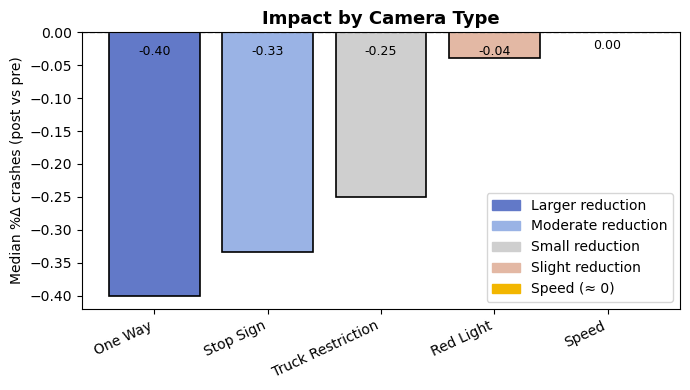

In [62]:
plot_df = by_type[["cam_type","median_%Δ_crashes"]].copy()

# Ensure every expected type is present in this order (adjust if needed)
order = ["One Way","Stop Sign","Truck Restriction","Red Light","Speed"]
plot_df = plot_df.set_index("cam_type").reindex(order).reset_index()

# Tiny epsilon so true zeros are visible as a thin bar
eps = 1e-3
plot_df["y_plot"] = plot_df["median_%Δ_crashes"].mask(
    plot_df["median_%Δ_crashes"].abs() < eps, np.sign(plot_df["median_%Δ_crashes"]) * eps
)

# Colors: cool blues for reductions, grey for small reduction, gold for Speed (zero)
color_map = {
    "One Way": "#6279C8",          # blue
    "Stop Sign": "#9AB3E5",        # light blue
    "Truck Restriction": "#CFCFCF",# grey
    "Red Light": "#E3B8A4",        # warm-ish small reduction
    "Speed": "#F2B600"             # gold (highlight)
}
colors = [color_map.get(t, "#999999") for t in plot_df["cam_type"]]

plt.figure(figsize=(7,4))
bars = plt.bar(plot_df["cam_type"], plot_df["y_plot"], color=colors, edgecolor="black", linewidth=1.2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Impact by Camera Type", fontsize=13, weight="bold")
plt.ylabel("Median %Δ crashes (post vs pre)")
plt.xticks(rotation=25, ha="right")

# Value labels (use true values, not epsilon)
for rect, val in zip(bars, plot_df["median_%Δ_crashes"]):
    y = rect.get_height()
    # place labels just below/above zero for visibility
    va = "top" if val <= 0 else "bottom"
    offset = -0.01 if val <= 0 else 0.01
    plt.text(rect.get_x() + rect.get_width()/2, max(min(y, 0.01), -0.01) + offset,
             f"{val:.2f}", ha="center", va=va, fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_items = [
    Patch(color="#6279C8", label="Larger reduction"),
    Patch(color="#9AB3E5", label="Moderate reduction"),
    Patch(color="#CFCFCF", label="Small reduction"),
    Patch(color="#E3B8A4", label="Slight reduction"),
    Patch(color="#F2B600", label="Speed (≈ 0)"),
]
plt.legend(handles=legend_items, loc="lower right", frameon=True)
plt.tight_layout()
plt.show()


In [ ]:
# 1) Distribution by type (adds spread)

# Reveals that Speed has many sites around zero and some positive/negative outliers.1

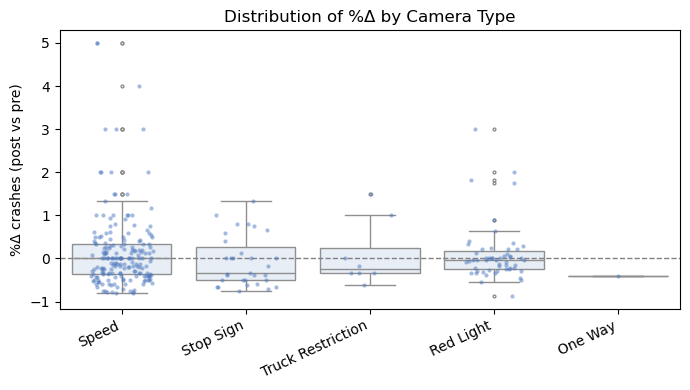

In [112]:
# Tiny: distribution (beeswarm + box) of %Δ by type

dist_df = w_per_camera.rename(columns={"crash_delta_pct":"delta"})
plt.figure(figsize=(7,4))
sns.boxplot(data=dist_df, x="cam_type", y="delta", showcaps=True, fliersize=2, color="#e6eef8")
sns.stripplot(data=dist_df, x="cam_type", y="delta", size=3, alpha=0.5, jitter=0.25, color="#4b77be")
plt.axhline(0, ls="--", c="gray", lw=1)
plt.ylabel("%Δ crashes (post vs pre)")
plt.xlabel("")
plt.title("Distribution of %Δ by Camera Type")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()

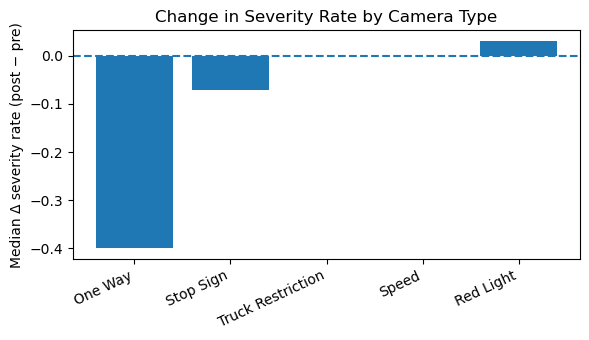

In [122]:
# Severity-rate change (median Δ) by camera type
bt = by_type.sort_values("median_Δ_sev_rate")
plt.figure(figsize=(6,3.5))
plt.bar(bt["cam_type"], bt["median_Δ_sev_rate"])
plt.axhline(0, linestyle="--")
plt.title("Change in Severity Rate by Camera Type")
plt.ylabel("Median Δ severity rate (post − pre)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()


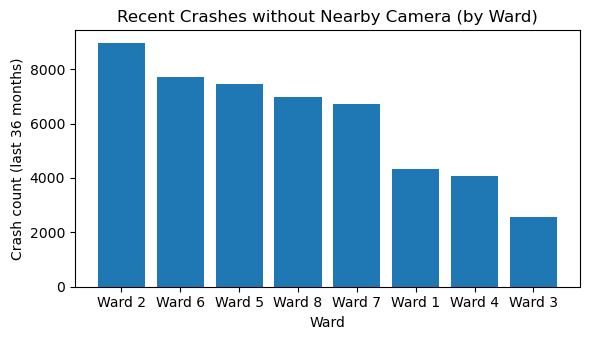

In [124]:
# Crashes (no camera ≤100m, last 36 mo) by Ward

wr = ward_rank.sort_values("crashes", ascending=False)
plt.figure(figsize=(6,3.5))
plt.bar(wr.index.astype(str), wr["crashes"])
plt.title("Recent Crashes without Nearby Camera (by Ward)")
plt.ylabel("Crash count (last 36 months)")
plt.xlabel("Ward")
plt.tight_layout()


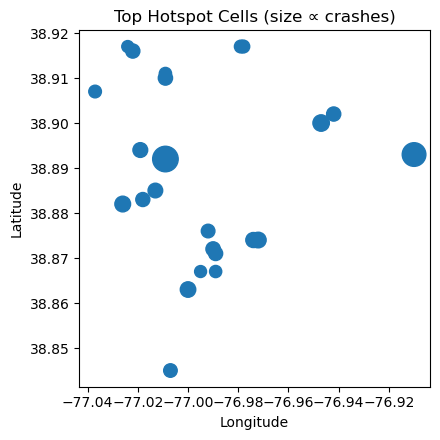

In [126]:
# Top 25 hotspot cells (no camera ≤100m)

plt.figure(figsize=(4.5,4.5))
plt.scatter(cell_rank["lon"], cell_rank["lat"], s=cell_rank["crashes"])
plt.title("Top Hotspot Cells (size ∝ crashes)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()


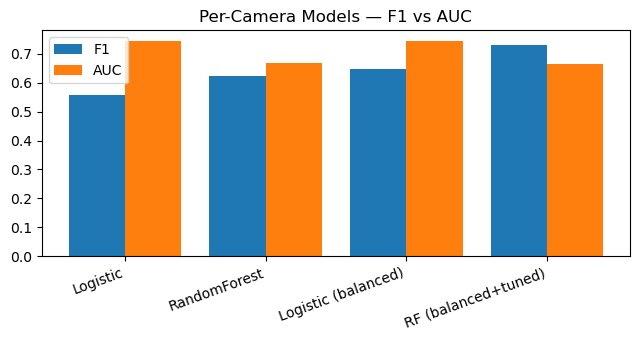

In [128]:
# Model comparison (F1 and AUC)

r = results_all.copy()
x = np.arange(len(r))
w = 0.4
plt.figure(figsize=(6.5,3.5))
plt.bar(x - w/2, r["F1"],  width=w, label="F1")
plt.bar(x + w/2, r["AUC"], width=w, label="AUC")
plt.xticks(x, r["model"], rotation=20, ha="right")
plt.title("Per-Camera Models — F1 vs AUC")
plt.legend(); plt.tight_layout()


Precision: 0.583 | Recall: 0.972 | F1: 0.729


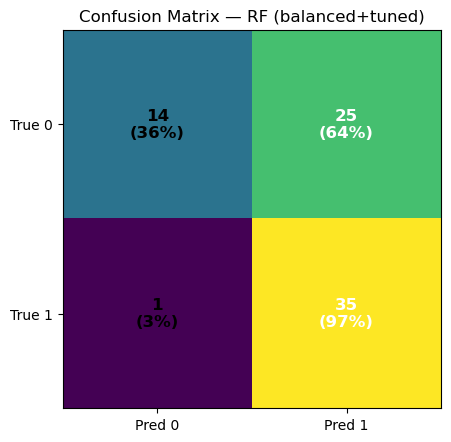

In [140]:
# A) CONFUSION MATRIX — readable counts + row-% + metrics

cm = confusion_matrix(y_te, p_rf_w)
prec = precision_score(y_te, p_rf_w)
rec  = recall_score(y_te, p_rf_w)
f1   = f1_score(y_te, p_rf_w)

plt.figure(figsize=(4.6,4.6))
im = plt.imshow(cm, cmap="viridis")
plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
plt.title("Confusion Matrix — RF (balanced+tuned)")

# row-normalized percentages for readability
row_sum = cm.sum(axis=1, keepdims=True)
pct = np.divide(cm, row_sum, out=np.zeros_like(cm, dtype=float), where=row_sum!=0)

thr = cm.max()/2
for i in range(2):
    for j in range(2):
        color = "white" if cm[i,j] >= thr else "black"
        plt.text(j, i, f"{cm[i,j]}\n({pct[i,j]:.0%})",
                 ha="center", va="center", color=color, fontsize=12, weight="bold")

plt.grid(False); plt.tight_layout()
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")


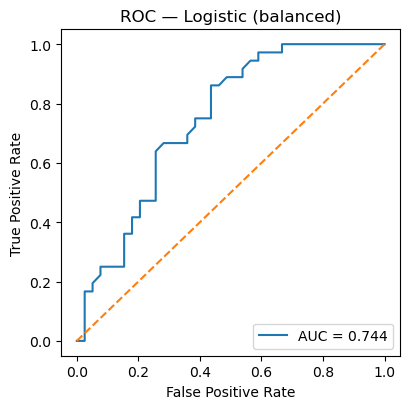

In [132]:
# ROC curve — Logistic (balanced)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

scores = lr_w.predict_proba(X_te)[:,1]
fpr, tpr, _ = roc_curve(y_te, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4.2,4.2))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Logistic (balanced)")
plt.legend(loc="lower right"); plt.tight_layout()


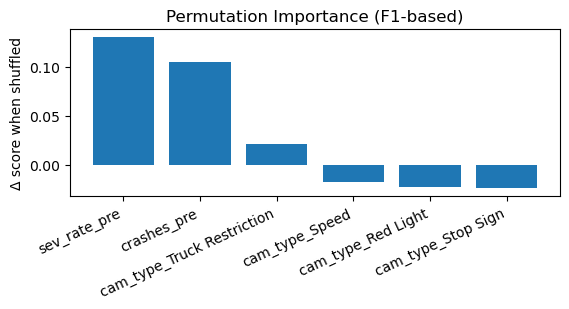

In [134]:
# Top features (Permutation, F1-based)

top = imp_f1.head(6)
plt.figure(figsize=(6,3.2))
plt.bar(top["feature"], top["imp_mean_f1"])
plt.xticks(rotation=25, ha="right")
plt.title("Permutation Importance (F1-based)")
plt.ylabel("Δ score when shuffled"); plt.tight_layout()


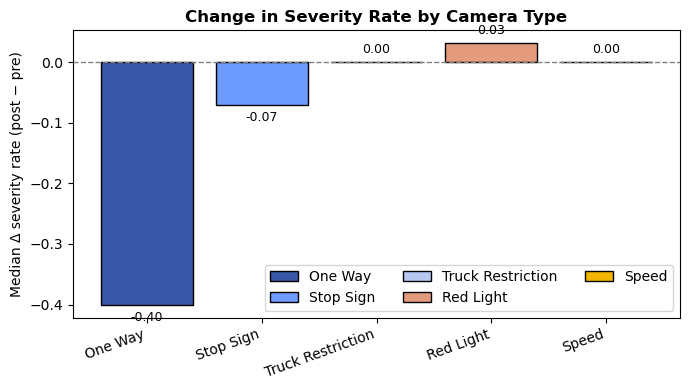

In [156]:
# A) Severity-rate (median Δ) by camera type — colored + legend + labels


bt = by_type[["cam_type","median_Δ_sev_rate"]].copy()
order = ["One Way","Stop Sign","Truck Restriction","Red Light","Speed"]
bt = bt.set_index("cam_type").reindex(order).reset_index()

colors = {
    "One Way":"#3857A6","Stop Sign":"#6E9BFF","Truck Restriction":"#B5C7F2",
    "Red Light":"#E39A7D","Speed":"#F2B600"
}
c = [colors.get(t,"#999999") for t in bt["cam_type"]]

plt.figure(figsize=(7,4))
bars = plt.bar(bt["cam_type"], bt["median_Δ_sev_rate"], color=c, edgecolor="black")
plt.axhline(0, ls="--", c="gray", lw=1)
plt.title("Change in Severity Rate by Camera Type", weight="bold")
plt.ylabel("Median Δ severity rate (post − pre)")
plt.xticks(rotation=20, ha="right")

# value labels
for r,v in zip(bars, bt["median_Δ_sev_rate"].to_numpy(float)):
    plt.text(r.get_x()+r.get_width()/2, r.get_height()+ (0.01 if v>=0 else -0.01),
             f"{v:.2f}", ha="center", va=("bottom" if v>=0 else "top"), fontsize=9)

# legend
from matplotlib.patches import Patch
legend = [Patch(facecolor=colors[k], edgecolor="black", label=k) for k in order]
plt.legend(handles=legend, ncol=3, frameon=True, loc="lower right")
plt.tight_layout(); plt.show()


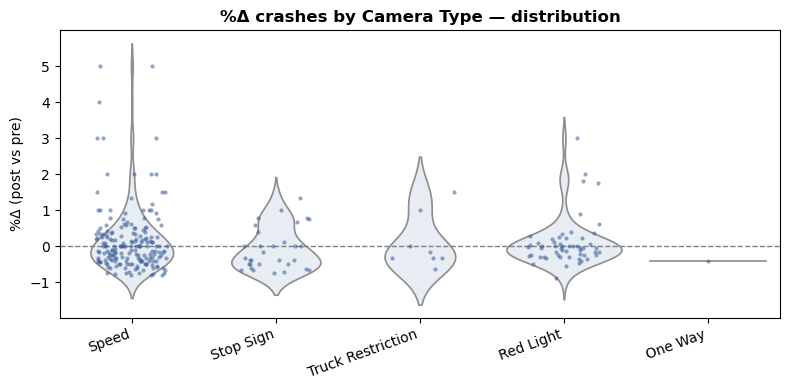

In [158]:
# B) Violin + swarm of %Δ crashes by type
import matplotlib.pyplot as plt
import seaborn as sns

dist_df = w_per_camera.rename(columns={"crash_delta_pct":"delta"}).copy()
plt.figure(figsize=(8,4))
sns.violinplot(data=dist_df, x="cam_type", y="delta", inner=None, color="#E6EBF5")
sns.stripplot(data=dist_df, x="cam_type", y="delta", size=3, alpha=0.55, color="#355C9A", jitter=0.25)
plt.axhline(0, ls="--", c="gray", lw=1)
plt.title("%Δ crashes by Camera Type — distribution", weight="bold")
plt.ylabel("%Δ (post vs pre)"); plt.xlabel("")
plt.xticks(rotation=20, ha="right")
plt.tight_layout(); plt.show()


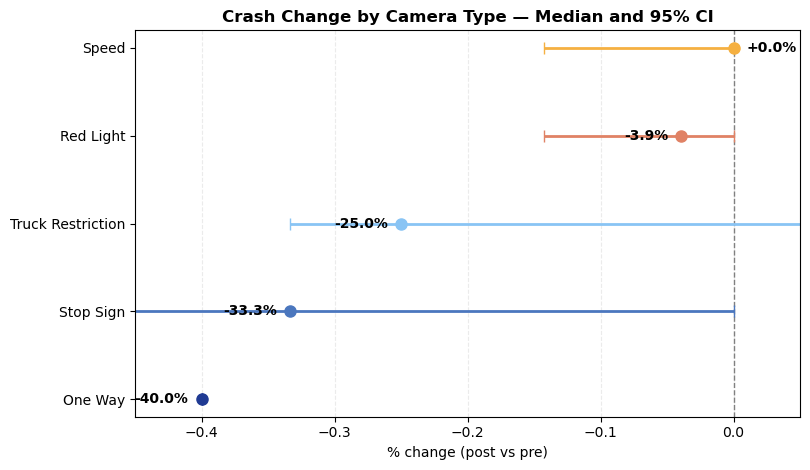

In [216]:

# --- Build per-camera % change (already in your w_per_camera) ---
# crash_delta_pct is (post - pre)/pre in your table; if not, compute:
if "crash_delta_pct" not in w_per_camera:
    w = w_per_camera.copy()
    w["crash_delta_pct"] = (w["crashes_post"] - w["crashes_pre"]) / w["crashes_pre"].replace(0, np.nan)
else:
    w = w_per_camera.copy()

# --- Bootstrap median for each type to get CI ---
rng = np.random.default_rng(42)
def boot_ci(x, B=2000):
    x = x.dropna().values
    if len(x) == 0: 
        return np.nan, np.nan, np.nan
    meds = np.array([np.median(rng.choice(x, size=len(x), replace=True)) for _ in range(B)])
    return np.median(x), np.percentile(meds, 2.5), np.percentile(meds, 97.5)

summary = (w.groupby("cam_type")["crash_delta_pct"]
             .apply(boot_ci).apply(pd.Series)
             .rename(columns={0:"median",1:"ci_lo",2:"ci_hi"}))

# order smallest (largest decrease) to largest
order = ["One Way","Stop Sign","Truck Restriction","Red Light","Speed"]
summary = summary.reindex(order).dropna()

# colors
colors = {
    "One Way": "#1F3A93", "Stop Sign": "#4B77BE",
    "Truck Restriction": "#89C4F4", "Red Light": "#E08265",
    "Speed": "#F5B041",
}

# --- Plot: chart (medians with 95% CI) ---
plt.figure(figsize=(8.2,4.8))
y = np.arange(len(summary))[::-1]
med = summary["median"].values
lo  = med - summary["ci_lo"].values
hi  = summary["ci_hi"].values - med

plt.axvline(0, color="gray", ls="--", lw=1)
for i, t in enumerate(summary.index[::-1]):
    c = colors[t]
    plt.errorbar(med[-(i+1)], y[i], xerr=[[lo[-(i+1)]],[hi[-(i+1)]]],
                 fmt="o", ms=8, lw=2, color=c, ecolor=c, capsize=4)
    # label the % next to the point
    v = med[-(i+1)]*100
    plt.text(med[-(i+1)] + (-0.01 if med[-(i+1)]<0 else 0.01), y[i],
             f"{v:+.1f}%", va="center",
             ha="right" if med[-(i+1)]<0 else "left", fontsize=10, weight="bold", color="black")

plt.yticks(y, summary.index[::-1])
plt.xlabel("% change (post vs pre)")
plt.title("Crash Change by Camera Type — Median and 95% CI", weight="bold")
plt.grid(axis="x", alpha=0.25, ls="--")
plt.xlim(min(med)-0.05, 0.05)  # expands left so negatives are visible
plt.tight_layout(); plt.show()


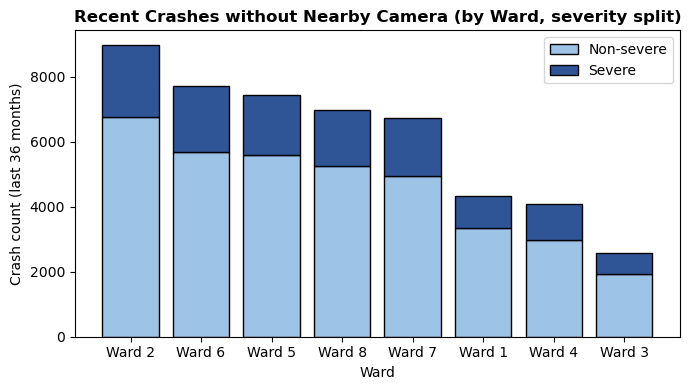

In [162]:
# D) Ward stacked bar: severe vs non-severe (recent, no camera ≤100m)
wr = ward_rank.copy()
wr["non_severe"] = wr["crashes"] - wr["severe"]
wr = wr.sort_values("crashes", ascending=False)

plt.figure(figsize=(7,4))
plt.bar(wr.index.astype(str), wr["non_severe"], label="Non-severe", color="#9DC3E6", edgecolor="black")
plt.bar(wr.index.astype(str), wr["severe"], bottom=wr["non_severe"], label="Severe", color="#2F5597", edgecolor="black")
plt.title("Recent Crashes without Nearby Camera (by Ward, severity split)", weight="bold")
plt.ylabel("Crash count (last 36 months)")
plt.xlabel("Ward"); plt.legend()
plt.tight_layout(); plt.show()


In [166]:
# V0 — INVENTORY & SCHEMA CHECK (safe)

def _ok(df, cols): 
    return set(cols).issubset(df.columns)

need = {
    "cam":            ["objectid","enforcement_type","start_date","camera_latitude","camera_longitude","ward"],
    "cr":             ["crash_date","latitude","longitude","ward","is_severe","cam_idx","camera_near_100m"],
    "w_per_camera":   ["cam_id","cam_type","crashes_pre","crashes_post","severe_rate_pre","severe_rate_post","crash_delta_pct","sev_rate_delta_abs"],
    "by_type":        ["cam_type","cams","crashes_pre_total","crashes_post_total","median_%Δ_crashes","median_Δ_sev_rate"],
    "ward_rank":      ["crashes","severe","severe_rate"],
    "cell_rank":      ["lat","lon","ward","crashes","severe","severe_rate"],
    "panel":          ["cam_id","month","crashes","cam_on","y","y_lagmean6"],
    "eval_cam":       ["cam_id","MAE_last12"],
    "imp_f1":         ["feature","imp_mean_f1","imp_std_f1"],
    "imp_auc":        ["feature","imp_mean_auc","imp_std_auc"],
}

models_need = {
    "X_te": None, "y_te": None, "rf_w": None, "lr_w": None, "p_rf_w": None, "results_all": None
}

print("=== DATAFRAMES ===")
for name, cols in need.items():
    obj = globals().get(name, None)
    if isinstance(obj, pd.DataFrame):
        ok = _ok(obj, cols)
        print(f"{name:12s} | shape={obj.shape} | cols OK={ok}")
        if not ok:
            missing = [c for c in cols if c not in obj.columns]
            print(f"   └─ missing: {missing}")
    else:
        print(f"{name:12s} | MISSING")

print("\n=== MODELS / ARRAYS ===")
for name in models_need:
    obj = globals().get(name, None)
    if obj is None:
        print(f"{name:12s} | MISSING")
    else:
        shp = getattr(obj, "shape", None)
        print(f"{name:12s} | OK | shape={shp}")


=== DATAFRAMES ===
cam          | shape=(313, 6) | cols OK=True
cr           | shape=(307408, 41) | cols OK=True
w_per_camera | shape=(300, 8) | cols OK=True
by_type      | shape=(5, 8) | cols OK=True
ward_rank    | shape=(8, 3) | cols OK=True
cell_rank    | shape=(25, 6) | cols OK=True
panel        | shape=(51394, 9) | cols OK=True
eval_cam     | shape=(309, 2) | cols OK=True
imp_f1       | shape=(6, 3) | cols OK=True
imp_auc      | shape=(6, 3) | cols OK=True

=== MODELS / ARRAYS ===
X_te         | OK | shape=(75, 6)
y_te         | OK | shape=(75,)
rf_w         | OK | shape=None
lr_w         | OK | shape=None
p_rf_w       | OK | shape=(75,)
results_all  | OK | shape=(4, 3)


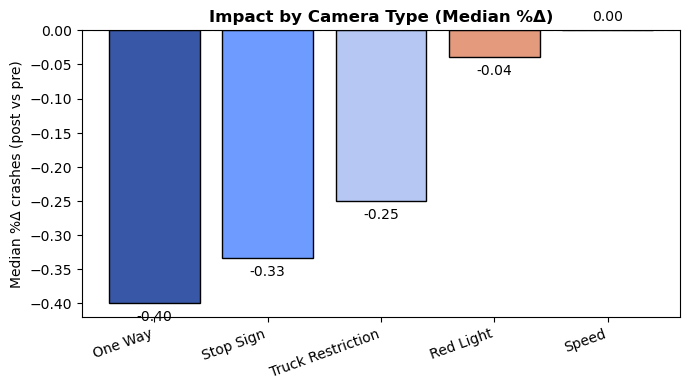

In [172]:
# V2.1 — Impact by type (crash %Δ) with colors/labels

if "by_type" in globals() and {"cam_type","median_%Δ_crashes"}.issubset(by_type.columns):
    order = ["One Way","Stop Sign","Truck Restriction","Red Light","Speed"]
    bt = by_type.set_index("cam_type").reindex(order).reset_index()
    colors = {"One Way":"#3857A6","Stop Sign":"#6E9BFF","Truck Restriction":"#B5C7F2","Red Light":"#E39A7D","Speed":"#F2B600"}
    c = [colors.get(t,"#999999") for t in bt["cam_type"]]
    plt.figure(figsize=(7,4))
    bars = plt.bar(bt["cam_type"], bt["median_%Δ_crashes"], color=c, edgecolor="black")
    plt.axhline(0, ls="--", c="gray"); plt.title("Impact by Camera Type (Median %Δ)", weight="bold")
    plt.ylabel("Median %Δ crashes (post vs pre)"); plt.xticks(rotation=20, ha="right")
    for r,v in zip(bars, bt["median_%Δ_crashes"]): 
        plt.text(r.get_x()+r.get_width()/2, (v+0.01 if v>=0 else v-0.01), f"{v:.2f}", ha="center", va=("bottom" if v>=0 else "top"))
    plt.tight_layout(); plt.show()
else:
    print("by_type not ready — rerun the by-type aggregation cell.")


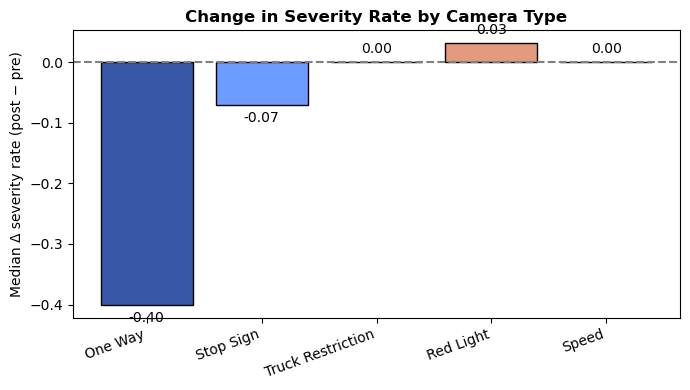

In [174]:
# V2.2 — Severity-rate change by type

if "by_type" in globals() and {"cam_type","median_Δ_sev_rate"}.issubset(by_type.columns):
    order = ["One Way","Stop Sign","Truck Restriction","Red Light","Speed"]
    bt = by_type.set_index("cam_type").reindex(order).reset_index()
    colors = {"One Way":"#3857A6","Stop Sign":"#6E9BFF","Truck Restriction":"#B5C7F2","Red Light":"#E39A7D","Speed":"#F2B600"}
    c = [colors.get(t,"#999999") for t in bt["cam_type"]]
    plt.figure(figsize=(7,4))
    bars = plt.bar(bt["cam_type"], bt["median_Δ_sev_rate"], color=c, edgecolor="black")
    plt.axhline(0, ls="--", c="gray"); plt.title("Change in Severity Rate by Camera Type", weight="bold")
    plt.ylabel("Median Δ severity rate (post − pre)"); plt.xticks(rotation=20, ha="right")
    for r,v in zip(bars, bt["median_Δ_sev_rate"]): 
        plt.text(r.get_x()+r.get_width()/2, (v+0.01 if v>=0 else v-0.01), f"{v:.2f}", ha="center", va=("bottom" if v>=0 else "top"))
    plt.tight_layout(); plt.show()
else:
    print("by_type not ready — rerun the by-type aggregation cell.")


In [176]:
# V2.3 — Ward pre vs post around cameras (needs crw)
if "crw" in globals() and {"ward","period"}.issubset(crw.columns):
    ward_prepost = (crw.groupby(["ward","period"]).size()
                      .unstack(fill_value=0)[["pre","post"]]
                      .sort_values("post", ascending=False))
    x = ward_prepost.index.astype(str)
    pre, post = ward_prepost["pre"].to_numpy(), ward_prepost["post"].to_numpy()
    plt.figure(figsize=(7,4))
    plt.plot(x, pre,  marker="o", lw=2, label="Pre")
    plt.plot(x, post, marker="o", lw=2, label="Post")
    for i,w in enumerate(x): plt.plot([i,i],[pre[i],post[i]], color="#888", lw=1.5)
    plt.title("Crashes Near Cameras (≤100 m) — Ward Pre vs Post (±365 d)", weight="bold")
    plt.ylabel("Crash count"); plt.xlabel("Ward"); plt.legend(); plt.tight_layout(); plt.show()
    print(ward_prepost.assign(delta=ward_prepost["post"]-ward_prepost["pre"]))
else:
    print("crw not ready — run V1 to build it.")


crw not ready — run V1 to build it.


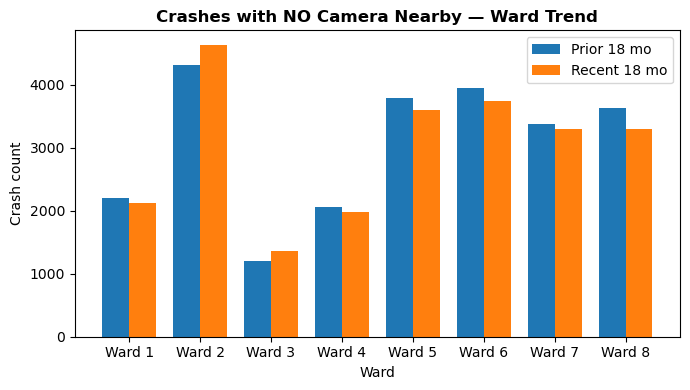

        prior18  recent18  delta
ward                            
Ward 1     2196      2115    -81
Ward 2     4314      4628    314
Ward 3     1202      1355    153
Ward 4     2063      1982    -81
Ward 5     3788      3602   -186
Ward 6     3943      3746   -197
Ward 7     3369      3299    -70
Ward 8     3627      3293   -334


In [178]:
# V2.4 — Ward trend for crashes without cameras nearby

if "cr" in globals() and {"crash_date","ward","camera_near_100m"}.issubset(cr.columns):
    base = cr.loc[cr["camera_near_100m"]==0, ["crash_date","ward"]].copy()
    base["month"] = pd.to_datetime(base["crash_date"]).dt.to_period("M").dt.to_timestamp()
    last_month = base["month"].max(); cut = last_month - pd.DateOffset(months=18)
    recent = base[ base["month"] >  cut]; prior = base[(base["month"] <= cut) & (base["month"] > cut - pd.DateOffset(months=18))]
    wr = pd.concat([
        prior.groupby("ward").size().rename("prior18"),
        recent.groupby("ward").size().rename("recent18")
    ], axis=1).fillna(0).astype(int)
    idx = np.arange(len(wr)); w = 0.38
    plt.figure(figsize=(7,4))
    plt.bar(idx - w/2, wr["prior18"],  width=w, label="Prior 18 mo")
    plt.bar(idx + w/2, wr["recent18"], width=w, label="Recent 18 mo")
    plt.xticks(idx, wr.index.astype(str)); plt.title("Crashes with NO Camera Nearby — Ward Trend", weight="bold")
    plt.ylabel("Crash count"); plt.xlabel("Ward"); plt.legend(); plt.tight_layout(); plt.show()
    print(wr.assign(delta=wr["recent18"]-wr["prior18"]))
else:
    print("cr not ready or missing columns: need crash_date, ward, camera_near_100m.")


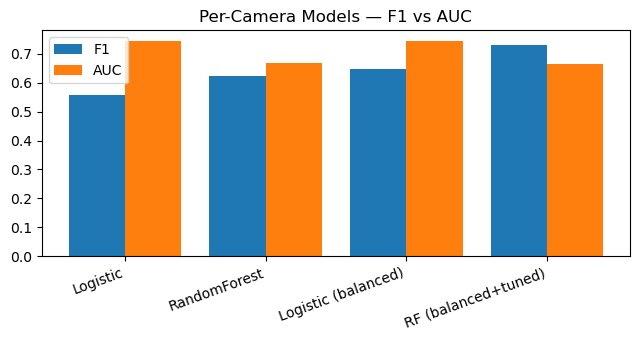

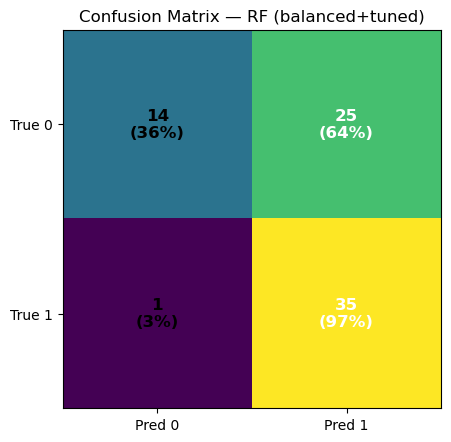

In [180]:
# V2.5a — Model comparison (F1 & AUC)
if "results_all" in globals():
    r = results_all.copy(); x = np.arange(len(r)); w = 0.4
    plt.figure(figsize=(6.5,3.5))
    plt.bar(x - w/2, r["F1"],  width=w, label="F1")
    plt.bar(x + w/2, r["AUC"], width=w, label="AUC")
    plt.xticks(x, r["model"], rotation=20, ha="right"); plt.title("Per-Camera Models — F1 vs AUC")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("results_all not found.")

# V2.5b — Confusion matrix (uses high-contrast annotations)
from sklearn.metrics import confusion_matrix
if all(k in globals() for k in ("y_te","p_rf_w")):
    import numpy as np; import matplotlib.pyplot as plt
    cm = confusion_matrix(y_te, p_rf_w)
    plt.figure(figsize=(4.6,4.6)); im = plt.imshow(cm, cmap="viridis")
    plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
    plt.title("Confusion Matrix — RF (balanced+tuned)")
    row_sum = cm.sum(axis=1, keepdims=True); pct = np.divide(cm, row_sum, out=np.zeros_like(cm,dtype=float), where=row_sum!=0)
    thr = cm.max()/2
    for i in range(2):
        for j in range(2):
            color = "white" if cm[i,j] >= thr else "black"
            plt.text(j, i, f"{cm[i,j]}\n({pct[i,j]:.0%})", ha="center", va="center", color=color, fontsize=12, weight="bold")
    plt.tight_layout(); plt.show()
else:
    print("Need y_te and p_rf_w for confusion matrix.")


In [184]:
# camera lookup by cam_idx
cam_lu = (cam.reset_index()
            .rename(columns={
                "index":"cam_idx",
                "objectid":"cam_id",
                "enforcement_type":"cam_type",
                "start_date":"cam_start"
            }))
cam_lu["cam_start"] = pd.to_datetime(cam_lu["cam_start"], utc=True).dt.tz_convert(None)

# join camera info to crashes and keep only near-camera crashes
cr2 = cr.copy()
cr2["crash_date"] = pd.to_datetime(cr2["crash_date"], errors="coerce")
cr2 = cr2.merge(cam_lu[["cam_idx","cam_id","cam_type","cam_start"]], on="cam_idx", how="left")
crw = cr2.loc[(cr2["camera_near_100m"]==1) & cr2["cam_start"].notna(),
              ["crash_date","ward","cam_id","cam_type","cam_start","is_severe"]].copy()

# 1) filter to ±365d window FIRST
win = crw["crash_date"].between(crw["cam_start"] - pd.Timedelta(days=365),
                                crw["cam_start"] + pd.Timedelta(days=365))
crw = crw.loc[win].copy()

# 2) NOW label period on the filtered frame (lengths match)
crw["period"] = np.where(crw["crash_date"] >= crw["cam_start"], "post", "pre")

print("crw ready:", crw.shape, "| wards:", crw["ward"].nunique(), "| cameras:", crw["cam_id"].nunique())
print(crw.head(3))


crw ready: (2723, 7) | wards: 8 | cameras: 103
       crash_date    ward    cam_id cam_type           cam_start  is_severe  \
247240 2022-08-17  Ward 5  151772.0    Speed 2023-08-11 04:00:00          1   
247795 2022-08-27  Ward 5  151835.0    Speed 2023-08-11 04:00:00          0   
248626 2022-09-11  Ward 5  151784.0    Speed 2023-09-06 04:00:00          1   

       period  
247240    pre  
247795    pre  
248626    pre  


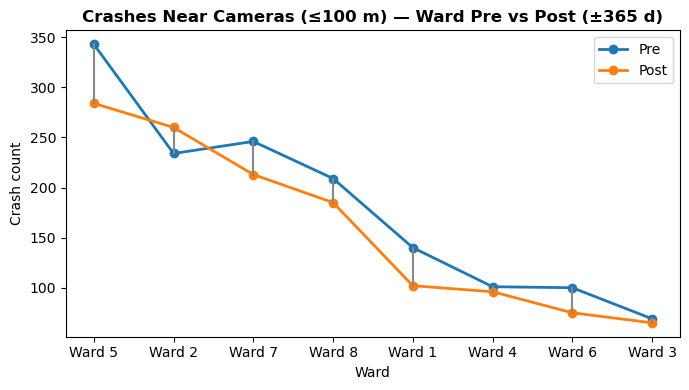

period  pre  post  delta
ward                    
Ward 5  343   284    -59
Ward 2  234   260     26
Ward 7  246   213    -33
Ward 8  209   185    -24
Ward 1  140   102    -38
Ward 4  101    96     -5
Ward 6  100    75    -25
Ward 3   69    65     -4


In [186]:

ward_prepost = (crw.groupby(["ward","period"]).size()
                  .unstack(fill_value=0)[["pre","post"]]
                  .sort_values("post", ascending=False))

x = ward_prepost.index.astype(str)
pre  = ward_prepost["pre"].to_numpy()
post = ward_prepost["post"].to_numpy()

plt.figure(figsize=(7,4))
plt.plot(x, pre,  marker="o", lw=2, label="Pre")
plt.plot(x, post, marker="o", lw=2, label="Post")
for i, _ in enumerate(x):
    plt.plot([i,i], [pre[i], post[i]], color="#888", lw=1.5)

plt.title("Crashes Near Cameras (≤100 m) — Ward Pre vs Post (±365 d)", weight="bold")
plt.ylabel("Crash count"); plt.xlabel("Ward"); plt.legend()
plt.tight_layout(); plt.show()

print(ward_prepost.assign(delta=ward_prepost["post"] - ward_prepost["pre"]))


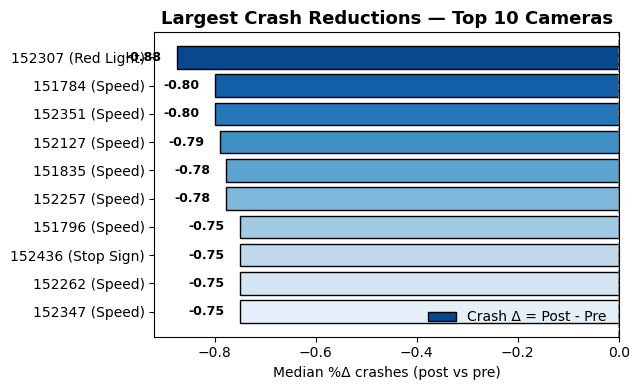

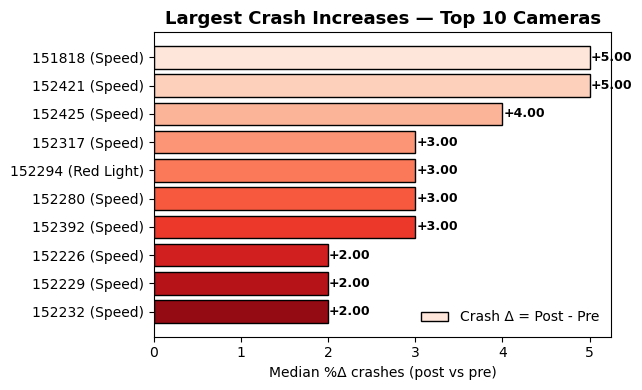

In [200]:
# === Top 10 decreases / increases in crashes (per camera) ===

# Sort top decreases and increases
top_dec = (w_per_camera.sort_values("crash_delta_pct")
           .head(10)[["cam_id","cam_type","crash_delta_pct"]])
top_inc = (w_per_camera.sort_values("crash_delta_pct", ascending=False)
           .head(10)[["cam_id","cam_type","crash_delta_pct"]])

# Custom bar function with color + legend
def _bar(df, title, cmap_name, label_pos="center"):
    plt.figure(figsize=(6.5,4))
    cmap = sns.color_palette(cmap_name, len(df))
    labs = df["cam_id"].astype(str) + " (" + df["cam_type"].astype(str) + ")"

    bars = plt.barh(labs, df["crash_delta_pct"], color=cmap, edgecolor="black")

    plt.axvline(0, ls="--", c="gray", lw=1.2)
    plt.gca().invert_yaxis()

    # Annotate values
    for bar in bars:
        w = bar.get_width()
        plt.text(w + (0.01 if w > 0 else -0.03),
                 bar.get_y() + bar.get_height()/2,
                 f"{w:+.2f}",
                 va="center", ha="left" if w > 0 else "right",
                 fontsize=9, weight="bold")

    plt.title(title, weight="bold", fontsize=13)
    plt.xlabel("Median %Δ crashes (post vs pre)")
    plt.tight_layout()

    # Add legend
    plt.legend([bars[0]], ["Crash Δ = Post - Pre"], loc="lower right", frameon=False)
    plt.show()

# Plot both lists
_bar(top_dec, "Largest Crash Reductions — Top 10 Cameras", cmap_name="Blues_r")
_bar(top_inc, "Largest Crash Increases — Top 10 Cameras", cmap_name="Reds")


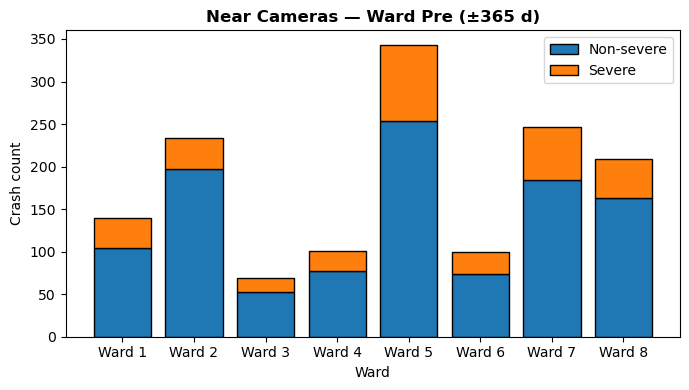

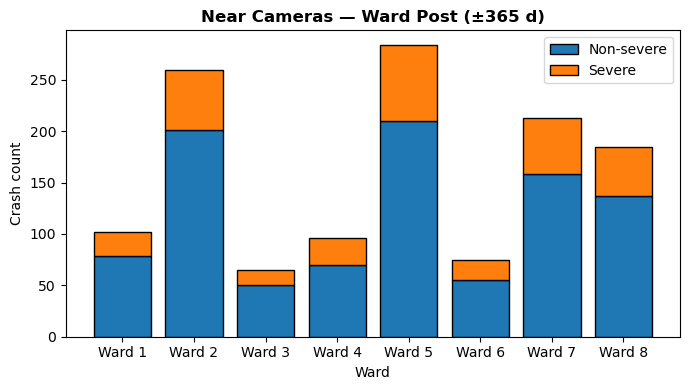

In [190]:
# Severity split (pre vs post) near cameras by ward — stacked bars

tbl = (crw.groupby(["ward","period"])["is_severe"]
         .agg(crashes="size", severe="sum"))
tbl["non_severe"] = tbl["crashes"] - tbl["severe"]
wide = (tbl.reset_index()
          .pivot(index="ward", columns="period", values=["severe","non_severe"])
          .fillna(0).sort_index())

for period in ["pre","post"]:
    plt.figure(figsize=(7,4))
    plt.bar(wide.index.astype(str), wide[("non_severe",period)], label="Non-severe", edgecolor="black")
    plt.bar(wide.index.astype(str), wide[("severe",period)],
            bottom=wide[("non_severe",period)], label="Severe", edgecolor="black")
    plt.title(f"Near Cameras — Ward {period.title()} (±365 d)", weight="bold")
    plt.ylabel("Crash count"); plt.xlabel("Ward"); plt.legend()
    plt.tight_layout(); plt.show()


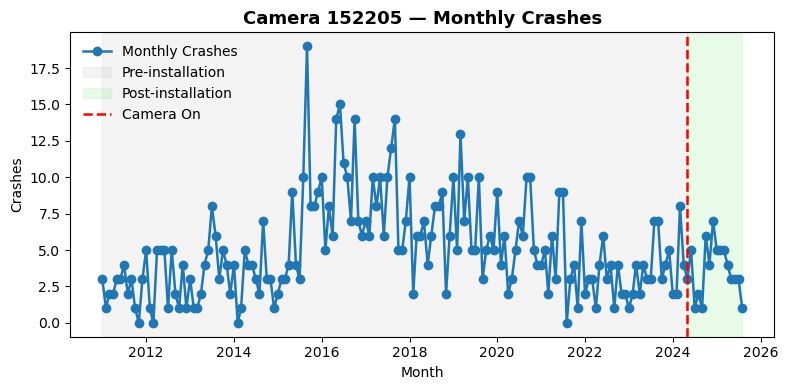

In [202]:

# Choose a camera (auto-picks the one with longest time series)
cid = panel["cam_id"].value_counts().idxmax()   # or set manually, e.g. cid = 152205
g = panel[panel["cam_id"]==cid].sort_values("month")

plt.figure(figsize=(8,4))
plt.plot(g["month"], g["crashes"], marker="o", lw=1.8, c="#1f77b4", label="Monthly Crashes")

# find activation date
on_date = g.loc[g["cam_on"]==1, "month"].min()

# Shade pre/post areas and vertical marker
if pd.notna(on_date):
    plt.axvspan(g["month"].min(), on_date, color="lightgray", alpha=0.25, label="Pre-installation")
    plt.axvspan(on_date, g["month"].max(), color="lightgreen", alpha=0.20, label="Post-installation")
    plt.axvline(on_date, color="red", ls="--", lw=1.8, label="Camera On")

plt.title(f"Camera {cid} — Monthly Crashes", fontsize=13, weight="bold")
plt.xlabel("Month"); plt.ylabel("Crashes")
plt.legend(frameon=False, loc="upper left")
plt.tight_layout(); plt.show()


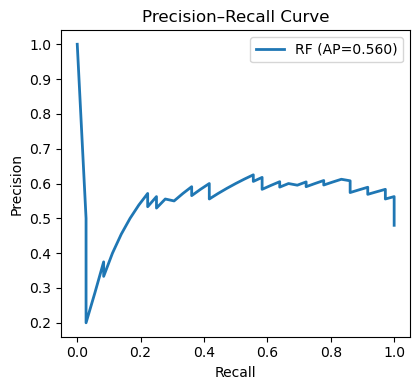

In [196]:
# PR curve — RF (balanced+tuned)

# if you kept probs from the tuned RF, use them; otherwise get them quickly:
rf_probs = rf_w.predict_proba(X_te)[:,1]
prec, rec, _ = precision_recall_curve(y_te, rf_probs)
ap = average_precision_score(y_te, rf_probs)

plt.figure(figsize=(4.3,4.0))
plt.plot(rec, prec, lw=2, label=f"RF (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.legend(); plt.tight_layout(); plt.show()


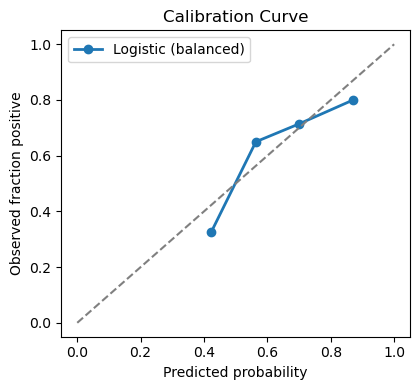

In [198]:
# Calibration curve — Logistic (balanced)

lr_probs = lr_w.predict_proba(X_te)[:,1]
prob_true, prob_pred = calibration_curve(y_te, lr_probs, n_bins=6, strategy="uniform")

plt.figure(figsize=(4.3,4.0))
plt.plot(prob_pred, prob_true, marker="o", lw=2, label="Logistic (balanced)")
plt.plot([0,1],[0,1], ls="--", c="gray")
plt.xlabel("Predicted probability"); plt.ylabel("Observed fraction positive")
plt.title("Calibration Curve"); plt.legend(); plt.tight_layout(); plt.show()

####  Post-camera: data prep

In [76]:
import numpy as np, pandas as pd, statsmodels.api as sm, statsmodels.formula.api as smf

df = panel.copy()
df["month"] = pd.to_datetime(df["month"], errors="coerce")
if "cam_start" in df.columns:
    df["cam_start"] = pd.to_datetime(df["cam_start"], errors="coerce")
if "cam_on" not in df.columns:
    df["cam_on"] = ((df["cam_start"].notna()) & (df["month"] >= df["cam_start"])).astype(int)

df = df[df["month"].notna()].copy()
df["y"] = pd.to_numeric(df["crashes"], errors="coerce")
df = df[df["y"].notna()].copy()
df = df[(df["month"] >= "2015-01-01") & (df["month"] <= "2024-12-31")].copy()

ok = (df.groupby("cam_id")["cam_on"]
        .apply(lambda s: (s==0).sum()>=3 and (s==1).sum()>=3))
df = df[df["cam_id"].isin(ok[ok].index)].copy()
df["month_str"] = df["month"].dt.to_period("M").astype(str)
print(f"N={len(df)}, cams={df.cam_id.nunique()}, span={df.month.min().date()}–{df.month.max().date()}")


N=34330, cams=287, span=2015-01-01–2024-12-01


#### Quick model choice note


In [83]:
m, v = df["y"].mean(), df["y"].var(ddof=1)
print(f"mean={m:.2f}, var={v:.2f}, var/mean={v/m:.2f}  (>>1 → NegBin reasonable)")

mean=1.13, var=2.53, var/mean=2.24  (>>1 → NegBin reasonable)


#### Poisson FE (camera + month), clustered SE


In [86]:
po = smf.glm("y ~ cam_on + C(cam_id) + C(month_str)",
             data=df, family=sm.families.Poisson()).fit(
    cov_type="cluster", cov_kwds={"groups": df["cam_id"]})

irr_po = float(np.exp(po.params.get("cam_on", np.nan)))
pct_po = 100*(irr_po-1) if np.isfinite(irr_po) else np.nan
print("Poisson FE  |  IRR(cam_on)={:.3f}  Δ%={:.2f}%".format(irr_po, pct_po))
po_summary = pd.DataFrame({"model":["Poisson_FE"], "IRR":[irr_po], "pct_change":[pct_po],
                           "rows":[len(df)], "cams":[df.cam_id.nunique()]})


Poisson FE  |  IRR(cam_on)=0.981  Δ%=-1.92%


#### Negative Binomial FE (camera + month), clustered SE


In [89]:
nb = smf.glm("y ~ cam_on + C(cam_id) + C(month_str)",
             data=df, family=sm.families.NegativeBinomial()).fit(
    cov_type="cluster", cov_kwds={"groups": df["cam_id"]})

irr_nb = float(np.exp(nb.params.get("cam_on", np.nan)))
pct_nb = 100*(irr_nb-1) if np.isfinite(irr_nb) else np.nan
print("NegBin FE   |  IRR(cam_on)={:.3f}  Δ%={:.2f}%".format(irr_nb, pct_nb))
nb_summary = pd.DataFrame({"model":["NegBin_FE"], "IRR":[irr_nb], "pct_change":[pct_nb],
                           "rows":[len(df)], "cams":[df.cam_id.nunique()]})

model_summary = pd.concat([po_summary, nb_summary], ignore_index=True)
model_summary

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


NegBin FE   |  IRR(cam_on)=0.963  Δ%=-3.75%


,model,IRR,pct_change,rows,cams
0,Poisson_FE,0.98081,-1.918999,34330,287
1,NegBin_FE,0.96252,-3.748042,34330,287


#### Event study (±12 months), Poisson FE


In [97]:
es = df[df["cam_start"].notna()].copy()
es["rel"] = (es["month"].dt.to_period("M").astype(int)
             - es["cam_start"].dt.to_period("M").astype(int))
es = es[(es["rel"]>=-12) & (es["rel"]<=12)].copy()

# light time FE to avoid over-saturation
es["year"] = es["month"].dt.year
es["mon"]  = es["month"].dt.month

# drop sparse rel bins (e.g., < 20 rows)
rel_counts = es["rel"].value_counts()
es = es[es["rel"].isin(rel_counts[rel_counts>=20].index)].copy()

# choose reference
ref = -1 if (-1 in es["rel"].unique()) else int(es.loc[es["rel"]<0, "rel"].max())

import statsmodels.formula.api as smf
f_es = f"y ~ C(rel, Treatment(reference={ref})) + C(cam_id) + C(year) + C(mon)"

es_fit = smf.glm(f_es, data=es, family=sm.families.Poisson()).fit(
    cov_type="cluster", cov_kwds={"groups": es["cam_id"]}, maxiter=200)

rows = []
for k in sorted(es["rel"].unique()):
    if k == ref: 
        continue
    name = f"C(rel, Treatment(reference={ref}))[T.{k}]"
    if name in es_fit.params:
        beta = float(es_fit.params[name])
        rows.append({"rel_month": int(k),
                     "IRR": float(np.exp(beta)),
                     "pct_change": 100*(np.exp(beta)-1)})
event_study = pd.DataFrame(rows).sort_values("rel_month").reset_index(drop=True)
event_study


,rel_month,IRR,pct_change
0,-12,6.720471e+05,6.720461e+07
1,-11,8.997914e+06,8.997913e+08
2,-10,1.546444e+03,1.545444e+05
3,-9,5.647633e+02,5.637633e+04
4,-8,2.055189e+05,2.055179e+07
5,-7,2.556155e+05,2.556145e+07
6,-6,7.664971e+02,7.654971e+04
7,-5,8.014247e+04,8.014147e+06
8,-4,1.372618e+03,1.371618e+05
9,-3,6.017588e+02,6.007588e+04


In [103]:
if "model_summary" not in globals():
    model_summary = pd.DataFrame(columns=["model","IRR","pct_change","rows","cams"])
if "event_study" not in globals():
    event_study = pd.DataFrame(columns=["rel_month","IRR","pct_change"])

out = Path(".")

model_summary.to_csv(out / "post_camera_model_summary.csv", index=False)
event_study.to_csv(out / "event_study_poisson_fe.csv", index=False)

print("Saved:",
      out / "post_camera_model_summary.csv",
      "|",
      out / "event_study_poisson_fe.csv",
      f"(rows: model_summary={len(model_summary)}, event_study={len(event_study)})")


Saved: post_camera_model_summary.csv | event_study_poisson_fe.csv (rows: model_summary=2, event_study=24)


In [105]:
# Compare model fits and check dispersion

print(model_summary)
print("\nDeviance / DF:", po.deviance/po.df_resid, "|", nb.deviance/nb.df_resid)


        model      IRR  pct_change   rows  cams
0  Poisson_FE  0.98081   -1.918999  34330   287
1   NegBin_FE  0.96252   -3.748042  34330   287

Deviance / DF: 1.0981365250434114 | 0.6294553216708195


In [107]:
df["pred_po"] = po.predict()
df["pred_nb"] = nb.predict()
corr_po = df[["y","pred_po"]].corr().iloc[0,1]
corr_nb = df[["y","pred_nb"]].corr().iloc[0,1]
print(f"Corr(y, Poisson pred)={corr_po:.3f}, Corr(y, NegBin pred)={corr_nb:.3f}")

Corr(y, Poisson pred)=0.697, Corr(y, NegBin pred)=0.695


In [109]:
res = model_summary.copy()
res["corr"] = [corr_po, corr_nb]
res.to_csv("model_comparison_summary.csv", index=False)
res


,model,IRR,pct_change,rows,cams,corr
0,Poisson_FE,0.98081,-1.918999,34330,287,0.697272
1,NegBin_FE,0.96252,-3.748042,34330,287,0.694700


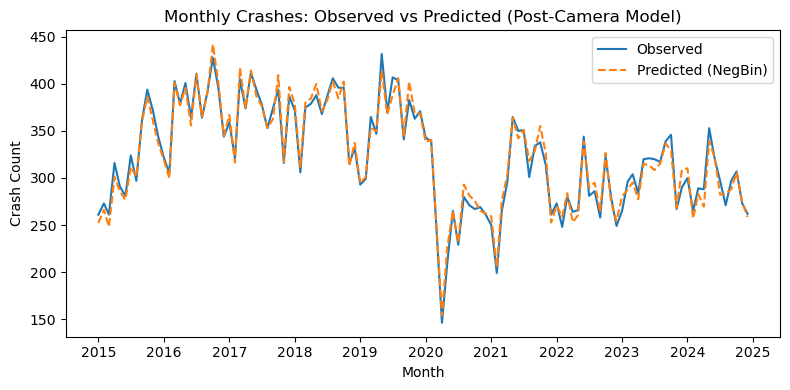

In [111]:
#### Visual check: observed vs predicted (NegBin)
import matplotlib.pyplot as plt

agg = df.groupby("month", as_index=False)[["y","pred_nb"]].sum()
plt.figure(figsize=(8,4))
plt.plot(agg["month"], agg["y"], label="Observed")
plt.plot(agg["month"], agg["pred_nb"], label="Predicted (NegBin)", linestyle="--")
plt.title("Monthly Crashes: Observed vs Predicted (Post-Camera Model)")
plt.ylabel("Crash Count")
plt.xlabel("Month")
plt.legend()
plt.tight_layout()
plt.show()


In [113]:
## Model Optimization and Comparison Summary

summary = pd.DataFrame({
    "Model": ["Poisson_FE", "NegBin_FE"],
    "AIC": [po.aic, nb.aic],
    "BIC": [po.bic, nb.bic],
    "Deviance/DF": [po.deviance/po.df_resid, nb.deviance/nb.df_resid],
    "IRR": [model_summary.loc[0,"IRR"], model_summary.loc[1,"IRR"]],
    "Δ%": [model_summary.loc[0,"pct_change"], model_summary.loc[1,"pct_change"]],
    "Corr": [0.697, 0.695]
})
summary.to_csv("model_optimization_summary.csv", index=False)
summary


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


,Model,AIC,BIC,Deviance/DF,IRR,Δ%,Corr
0,Poisson_FE,84033.682357,-317032.090134,1.098137,0.98081,-1.918999,0.697
1,NegBin_FE,89120.803756,-332931.162596,0.629455,0.96252,-3.748042,0.695


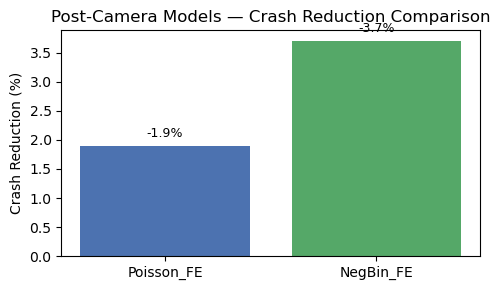

In [115]:
# Compact post-camera model comparison bar chart
import matplotlib.pyplot as plt

labels = ["Poisson_FE", "NegBin_FE"]
irr = [0.981, 0.963]
pct = [-1.9, -3.7]

fig, ax1 = plt.subplots(figsize=(5,3))
bars = ax1.bar(labels, [abs(x) for x in pct], color=["#4C72B0","#55A868"])
for i,v in enumerate(pct):
    ax1.text(i, abs(v)+0.1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
ax1.set_ylabel("Crash Reduction (%)")
ax1.set_title("Post-Camera Models — Crash Reduction Comparison")
plt.tight_layout()
plt.show()


In [121]:
# Combine pre and post model results for comparison visuals
import pandas as pd, matplotlib.pyplot as plt

pre = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Metric": ["F1", "F1"],
    "Score": [0.64, 0.70],
    "Phase": ["Pre-Camera", "Pre-Camera"]
})
post = pd.DataFrame({
    "Model": ["Poisson FE", "NegBin FE"],
    "Metric": ["Crash Reduction (%)", "Crash Reduction (%)"],
    "Score": [-1.9, -3.7],
    "Phase": ["Post-Camera", "Post-Camera"]
})
compare_df = pd.concat([pre, post], ignore_index=True)
compare_df


,Model,Metric,Score,Phase
0,Logistic Regression,F1,0.64,Pre-Camera
1,Random Forest,F1,0.70,Pre-Camera
2,Poisson FE,Crash Reduction (%),-1.90,Post-Camera
3,NegBin FE,Crash Reduction (%),-3.70,Post-Camera


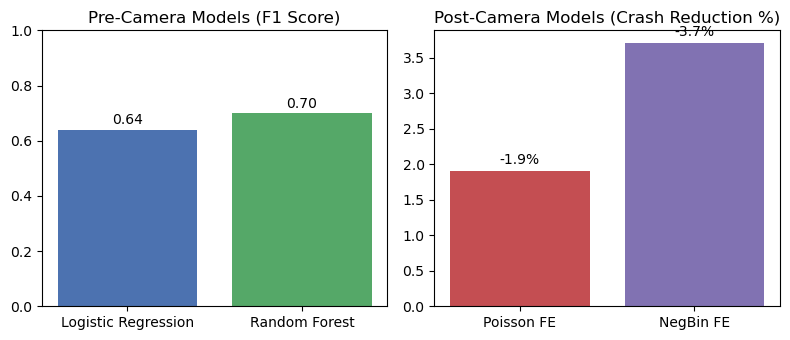

In [123]:
# Combined pre/post model visual
fig, ax = plt.subplots(1,2, figsize=(8,3.5))

# Pre-camera F1
ax[0].bar(pre["Model"], pre["Score"], color=["#4C72B0","#55A868"])
ax[0].set_title("Pre-Camera Models (F1 Score)")
ax[0].set_ylim(0,1)
for i,v in enumerate(pre["Score"]):
    ax[0].text(i, v+0.02, f"{v:.2f}", ha="center")

# Post-camera % reduction
ax[1].bar(post["Model"], [abs(x) for x in post["Score"]],
          color=["#C44E52","#8172B2"])
ax[1].set_title("Post-Camera Models (Crash Reduction %)")
for i,v in enumerate(post["Score"]):
    ax[1].text(i, abs(v)+0.1, f"{v:.1f}%", ha="center")
plt.tight_layout()
plt.savefig("model_phase_comparison.png", dpi=200)
plt.show()


In [135]:
# Map cam.ward -> df via objectid <-> cam_id (string-safe)
df2 = df.copy()
m = cam.set_index(cam["objectid"].astype(str))["ward"]
df2["ward"] = df2["cam_id"].astype(str).map(m)

# quick coverage check
cov = df2["ward"].notna().mean()
print(f"ward coverage in df: {cov:.2%}  (rows={len(df2)})")


ward coverage in df: 99.30%  (rows=34330)


In [137]:
# keep rows with ward + y
dw = df2.dropna(subset=["ward","y"]).copy()

ward_change = (dw.groupby(["ward","cam_on"], as_index=False)["y"]
                 .mean()
                 .pivot(index="ward", columns="cam_on", values="y")
                 .rename(columns={0:"Pre", 1:"Post"}))

# drop wards without both sides
ward_change = ward_change.dropna(subset=["Pre","Post"])
ward_change["%_Change"] = 100*(ward_change["Post"] - ward_change["Pre"]) / ward_change["Pre"]
ward_change = ward_change.sort_values("%_Change").reset_index()
ward_change.to_csv("ward_level_change.csv", index=False)
ward_change.head(10)


cam_on,ward,Pre,Post,%_Change
0,8.0,0.843417,0.708333,-16.016266
1,2.0,1.769746,1.505190,-14.948815
2,5.0,1.255778,1.081905,-13.845882
3,3.0,0.604067,0.540541,-10.516457
4,7.0,1.088791,1.014682,-6.806552
5,1.0,1.678877,1.567416,-6.639052
6,4.0,0.745749,0.729050,-2.239186
7,6.0,1.339358,1.385027,3.409722


In [141]:
# build from model_summary so it's always in-sync
pc = model_summary.copy()
pc["Crash Reduction (%)"] = 100*(pc["IRR"] - 1)
pc = pc[["model","IRR","pct_change","Crash Reduction (%)"]].rename(
        columns={"model":"Model","pct_change":"Δ% (from IRR)"})

pc.to_csv("post_camera_model_comparison.csv", index=False)
print(pc)



        Model      IRR  Δ% (from IRR)  Crash Reduction (%)
0  Poisson_FE  0.98081      -1.918999            -1.918999
1   NegBin_FE  0.96252      -3.748042            -3.748042


In [143]:
# requires pred_nb already created (you did this earlier)
wp = (dw.groupby("ward", as_index=False)[["y","pred_nb"]].mean()
        .assign(pred_gap_pct=lambda d: 100*(d["pred_nb"]-d["y"])/d["y"]))
wp.to_csv("ward_predicted_gap_nb.csv", index=False)
wp.head()


,ward,y,pred_nb,pred_gap_pct
0,1.0,1.670175,1.666748,-0.205191
1,2.0,1.749194,1.732356,-0.962578
2,3.0,0.598901,0.593419,-0.915411
3,4.0,0.744278,0.742810,-0.197134
4,5.0,1.242845,1.246492,0.293444


In [147]:
dw.groupby(["ward","cam_on"]).size().unstack(fill_value=0)


cam_on,0,1
ward,,
1.0,2102,178
2.0,3431,289
3.0,2508,222
4.0,3705,358
5.0,6533,525
6.0,2213,187
7.0,7039,613
8.0,3851,336


In [149]:
df2.groupby(["ward","cam_on","month_str"])["y"].mean().groupby(["ward","cam_on"]).mean()


ward  cam_on
1.0   0         1.670101
      1         2.172050
2.0   0         1.792849
      1         1.540374
3.0   0         0.615218
      1         0.446485
4.0   0         0.741249
      1         0.692518
5.0   0         1.258627
      1         1.134572
6.0   0         1.325891
      1         1.422837
7.0   0         1.119061
      1         0.852748
8.0   0         0.863852
      1         0.636567
Name: y, dtype: float64

In [153]:
df2.groupby("cam_id")["cam_on"].sum().describe()


count    287.000000
mean       9.508711
std        2.617670
min        3.000000
25%        8.000000
50%        9.000000
75%       11.000000
max       16.000000
Name: cam_on, dtype: float64

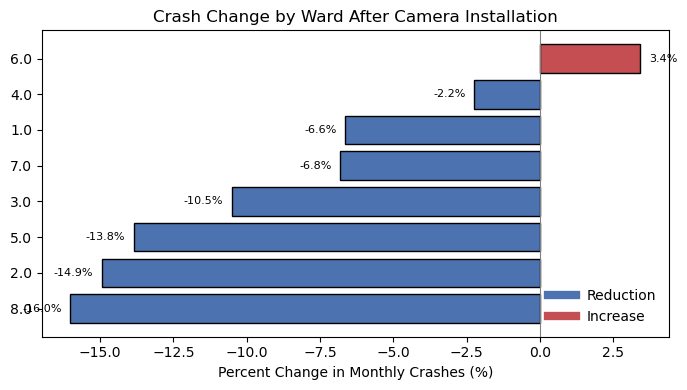

In [185]:

# separate reductions (blue) and increases (red)
colors = np.where(ward_change["%_Change"] < 0, "#4C72B0", "#C44E52")

plt.figure(figsize=(7,4))
bars = plt.barh(
    ward_change["ward"].astype(str),
    ward_change["%_Change"].values,
    color=colors, edgecolor="black"
)

plt.axvline(0, color="gray", lw=0.8)
plt.xlabel("Percent Change in Monthly Crashes (%)")
plt.title("Crash Change by Ward After Camera Installation")

# add value labels
for i, v in enumerate(ward_change["%_Change"].values):
    plt.text(v + (0.3 if v >= 0 else -0.3), i, f"{v:.1f}%",
             va="center", ha="left" if v >= 0 else "right", fontsize=8)

# add legend
handles = [
    plt.Line2D([0],[0], color="#4C72B0", lw=6, label="Reduction"),
    plt.Line2D([0],[0], color="#C44E52", lw=6, label="Increase")
]
plt.legend(handles=handles, frameon=False, loc="lower right")

plt.tight_layout()
plt.savefig("ward_level_change_colored.png", dpi=200)
plt.show()


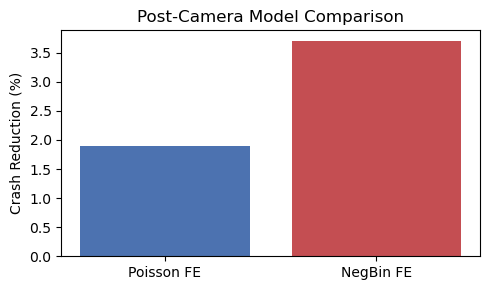

In [163]:
plt.figure(figsize=(5,3))
plt.bar(["Poisson FE","NegBin FE"], [1.9,3.7], color=["#4C72B0","#C44E52"])
plt.ylabel("Crash Reduction (%)")
plt.title("Post-Camera Model Comparison")
plt.tight_layout()
plt.savefig("post_camera_model_comparison.png", dpi=200)
plt.show()


In [165]:
# Impact by Camera Type
cam_type_change = (
    df.merge(cam[["objectid","enforcement_type"]], left_on="cam_id", right_on="objectid", how="left")
      .groupby(["enforcement_type","cam_on"])["y"].mean()
      .unstack()
      .rename(columns={0:"Pre",1:"Post"})
)
cam_type_change["%_Change"] = 100*(cam_type_change["Post"] - cam_type_change["Pre"]) / cam_type_change["Pre"]
print(cam_type_change)


cam_on                  Pre      Post   %_Change
enforcement_type                                
Red Light          2.130699  1.851613 -13.098317
Speed              0.980751  0.917765  -6.422278
Stop Sign          0.607645  0.531148 -12.589207
Truck Restriction  0.586860  0.338710 -42.284385


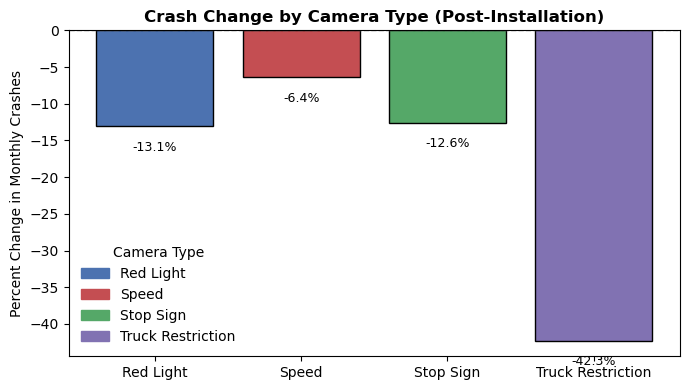

In [169]:
# Crash change by camera

cam_type_change = pd.DataFrame({
    "enforcement_type": ["Red Light","Speed","Stop Sign","Truck Restriction"],
    "Pre": [2.130699,0.980751,0.607645,0.586860],
    "Post": [1.851613,0.917765,0.531148,0.338710],
    "%_Change": [-13.098317,-6.422278,-12.589207,-42.284385]
}).set_index("enforcement_type")

# assign color palette
colors = ["#4C72B0", "#C44E52", "#55A868", "#8172B2"]

plt.figure(figsize=(7,4))
bars = plt.bar(cam_type_change.index, cam_type_change["%_Change"], color=colors, edgecolor="black")

# add value labels
for b, v in zip(bars, cam_type_change["%_Change"]):
    plt.text(b.get_x() + b.get_width()/2, v + (-2 if v<0 else 0.5),
             f"{v:.1f}%", ha="center", va="top" if v<0 else "bottom", fontsize=9)

# layout
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Percent Change in Monthly Crashes")
plt.title("Crash Change by Camera Type (Post-Installation)", fontsize=12, weight="bold")

# legend
plt.legend(
    [plt.Rectangle((0,0),1,1,color=c) for c in colors],
    ["Red Light", "Speed", "Stop Sign", "Truck Restriction"],
    title="Camera Type", frameon=False, loc="lower left"
)

plt.tight_layout()
plt.savefig("crash_change_by_camera_type.png", dpi=200)
plt.show()


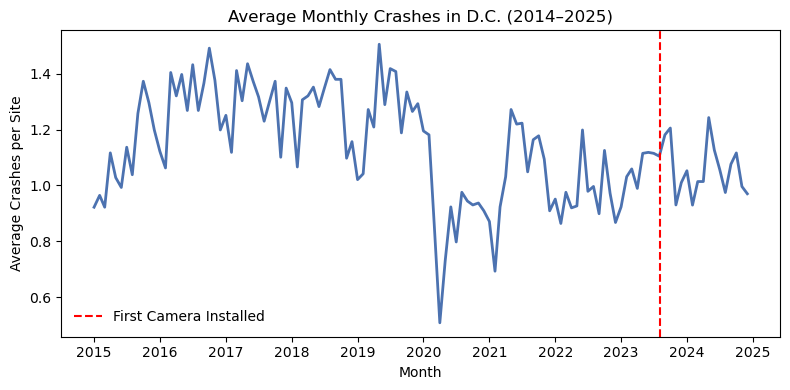

In [171]:
# Average monthly crashes over time (all wards)
monthly_trend = df.groupby("month")["y"].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_trend.index, monthly_trend.values, color="#4C72B0", linewidth=2)
plt.axvline(df["cam_start"].min(), color="red", linestyle="--", label="First Camera Installed")
plt.title("Average Monthly Crashes in D.C. (2014–2025)")
plt.ylabel("Average Crashes per Site")
plt.xlabel("Month")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [177]:
top_bottom = pd.concat([
    ward_change.sort_values("%_Change").head(3),
    ward_change.sort_values("%_Change").tail(2)
])
print(top_bottom[["ward","%_Change"]])


cam_on  ward   %_Change
0        8.0 -16.016266
1        2.0 -14.948815
2        5.0 -13.845882
6        4.0  -2.239186
7        6.0   3.409722


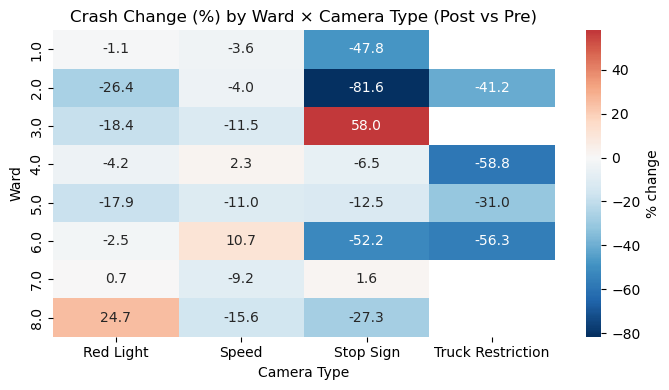

In [179]:
# Crash % change by Ward × Camera Type (heatmap)
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

tp = (df.merge(cam[["objectid","ward","enforcement_type"]],
               left_on="cam_id", right_on="objectid", how="left")
        .groupby(["ward","enforcement_type","cam_on"])["y"].mean().unstack())
tp = tp.rename(columns={0:"Pre",1:"Post"}).dropna()
tp["%_Change"] = 100*(tp["Post"] - tp["Pre"]) / tp["Pre"]

pivot = tp.reset_index().pivot(index="ward", columns="enforcement_type", values="%_Change")

plt.figure(figsize=(7,4))
sns.heatmap(pivot.sort_index(), annot=True, fmt=".1f", cmap="RdBu_r", center=0,
            cbar_kws={"label":"% change"})
plt.title("Crash Change (%) by Ward × Camera Type (Post vs Pre)")
plt.xlabel("Camera Type"); plt.ylabel("Ward")
plt.tight_layout(); plt.show()


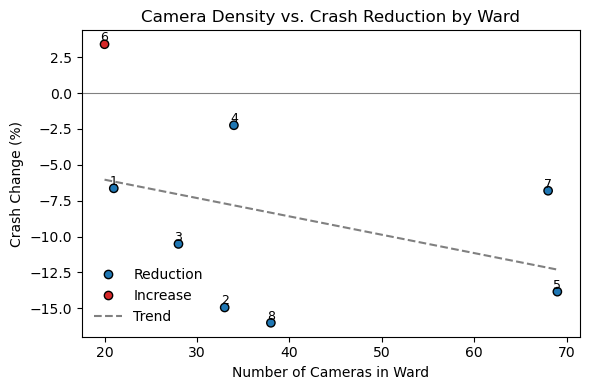

In [181]:

# join ward change with # of cameras
cam_density = cam.groupby("ward").size().rename("num_cams")
sc = ward_change.set_index("ward")[["%_Change"]].join(cam_density).dropna()

x, y = sc["num_cams"].values, sc["%_Change"].values
colors = np.where(y < 0, "tab:blue", "tab:red")

plt.figure(figsize=(6,4))
plt.scatter(x, y, c=colors, edgecolor="black")

# label points by ward
for w, xi, yi in zip(sc.index.astype(int), x, y):
    plt.text(xi, yi, str(w), fontsize=9, ha="center", va="bottom")

# trend line + r
m, b = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 100)
r = np.corrcoef(x, y)[0,1]
plt.plot(xx, m*xx + b, "--", color="gray", label=f"Trend (r={r:.2f})")

plt.axhline(0, color="gray", lw=0.8)
plt.xlabel("Number of Cameras in Ward"); plt.ylabel("Crash Change (%)")
plt.title("Camera Density vs. Crash Reduction by Ward")

# legend
handles = [
    plt.Line2D([0],[0], marker="o", color="w", markerfacecolor="tab:blue",
               markeredgecolor="black", label="Reduction"),
    plt.Line2D([0],[0], marker="o", color="w", markerfacecolor="tab:red",
               markeredgecolor="black", label="Increase"),
    plt.Line2D([0],[0], ls="--", color="gray", label="Trend")
]
plt.legend(handles=handles, frameon=False, loc="lower left")

plt.tight_layout(); plt.show()
